# Carga de librerias necesarias

%pip install folium   
%pip install geopy   
%pip install geopandas   
%pip install dash-bootstrap-components   
%pip install dash   
%pip install tabulate

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker # per poder utilitzar FuncFormatter i aplicar format a la barra
import geopandas as gpd
import time
import folium
import os
import re
from mysql.connector import errorcode
from dotenv import load_dotenv # type: ignore # per dades accedir base dades
from datetime import datetime
from matplotlib.ticker import FuncFormatter # per poder utilitzar el separador de milersimport geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import Point
from geopy.exc import GeocoderTimedOut
from folium.plugins import MarkerCluster
from tabulate import tabulate # para formato de una tabla
from scipy.stats import skew
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer

#Librerías sk-learn para la imputación de review_nulas
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

#Para la validación cruzada
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

#Librería para gráficos interactivos en python
import plotly.graph_objects as go
import plotly.express as px

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyproj/__init__.py:96: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_DATA (PROJ 9.1+) | PROJ_LIB (PROJ<9.1) or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


# Descarga de archivo CSV

In [2]:
path = r"..//Data//2025_04_28_Sprint03_bruto.csv"

df = pd.read_csv(path)



# Limpieza

## Comprobar dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   apartment_id                 10000 non-null  int64  
 1   name                         9997 non-null   object 
 2   description                  9862 non-null   object 
 3   host_id                      10000 non-null  int64  
 4   neighbourhood_name           10000 non-null  object 
 5   neighbourhood_district       6079 non-null   object 
 6   room_type                    10000 non-null  object 
 7   accommodates                 10000 non-null  int64  
 8   bathrooms                    9926 non-null   float64
 9   bedrooms                     9930 non-null   float64
 10  beds                         9955 non-null   float64
 11  amenities_list               9983 non-null   object 
 12  price                        9746 non-null   float64
 13  minimum_nights   

## Cambio de tipo de datos de fechas

In [4]:
df[['first_review_date','last_review_date','insert_date']]

,first_review_date,last_review_date,insert_date
0,02/01/2010,05/09/2017,31/07/2018
1,10/10/2014,15/07/2018,10/01/2020
2,05/01/2011,22/07/2019,29/07/2019
3,13/03/2012,04/01/2020,10/01/2020
4,08/07/2011,08/08/2018,19/02/2019
...,...,...,...
9995,NaN,NaN,31/01/2021
9996,NaN,NaN,27/02/2021
9997,NaN,NaN,31/01/2021
9998,NaN,NaN,09/02/2021


In [5]:
date_cols = ['first_review_date', 'last_review_date', 'insert_date']
df[date_cols] = df[date_cols].apply(lambda col: pd.to_datetime(col, format='%d/%m/%Y', errors='coerce'))
df = df.astype({'bathrooms': 'Int64', 'bedrooms': 'Int64', 'beds': 'Int64'})

df[['first_review_date','last_review_date','insert_date','bathrooms','bedrooms','beds']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   first_review_date  7396 non-null   datetime64[ns]
 1   last_review_date   7395 non-null   datetime64[ns]
 2   insert_date        10000 non-null  datetime64[ns]
 3   bathrooms          9926 non-null   Int64         
 4   bedrooms           9930 non-null   Int64         
 5   beds               9955 non-null   Int64         
dtypes: Int64(3), datetime64[ns](3)
memory usage: 498.2 KB


## Duplicados

### Funcion de duplicados

In [6]:
def mantener_fecha_mas_reciente(df, columna_id, columna_fecha):
    """
    Elimina duplicados basados en un ID, manteniendo la fila con la fecha más reciente.
    
    Parámetros:
    df (DataFrame): El DataFrame que contiene los datos.
    columna_id (str): El nombre de la columna que identifica los duplicados.
    columna_fecha (str): El nombre de la columna que contiene las fechas.

    Retorna:
    DataFrame: Un nuevo DataFrame con los IDs únicos y sus fechas más recientes.
    """

    # Ordenar por fecha descendente
    df = df.sort_values(by=columna_fecha, ascending=False)

    # Eliminar duplicados manteniendo el más reciente
    df = df.drop_duplicates(subset=columna_id, keep='last')

    return df



#### Numero de registros duplicados

In [7]:
total_registros = len(df)
valores_unicos = df['apartment_id'].nunique()
duplicados = total_registros - valores_unicos
print(f"Registros duplicados: {duplicados}")
print(f"Registros que deberían quedar: {valores_unicos}")

Registros duplicados: 350
Registros que deberían quedar: 9650


### Ejecutar funcion al dataset con el ID del apartamento y la fecha de insersion 

In [8]:
df = mantener_fecha_mas_reciente(df, columna_id='apartment_id', columna_fecha='insert_date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9650 entries, 3092 to 2456
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9514 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9584 non-null   Int64         
 9   bedrooms                     9583 non-null   Int64         
 10  beds                         9605 non-null   Int64         
 11  amenities_list               9633 non-null   

In [9]:
df[df['amenities_list'].isna()]

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date
1115,5210987,Single room in Castellana/Chamartin,Very lightfull & modern single room in a luxur...,2563986,Hispanoam�rica,Chamart�n,Private room,1,1,1,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,madrid,2020-03-17
1096,5121791,Genial habitaci�n en Gracia,Habitaci�n grande y balc�n propio. Muy luminos...,26471057,la Vila de Gr�cia,Gr�cia,Private room,1,1,1,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,barcelona,2020-02-16
5188,21271313,Pol62-Rustica,The villa is in a rural setting surrounded by ...,98002653,Pollen�a,NaN,Entire home/apt,6,2,3,...,60.0,70.0,70.0,80.0,60.0,VERDADERO,7.0,spain,mallorca,2019-12-31
3017,15031239,TIPI on the land of Finca s'Almudaina Montuiri,"Sacred place with beautiful surroundings, be d...",5275866,Montu�ri,NaN,Entire home/apt,2,1,1,...,90.0,100.0,100.0,100.0,100.0,FALSO,7.0,spain,mallorca,2019-10-28
4970,20562314,Art Villa S'Agar�,El Art Villa S�Agar� es una encantadora villa ...,143723965,Castell-Platja d'Aro,NaN,Private room,4,1,1,...,100.0,90.0,100.0,90.0,90.0,FALSO,17.0,spain,girona,2019-06-30
1650,7948633,Mallorca desconocida,"La casa est� muy cerca del pueblo de Lloseta, ...",41916589,Lloseta,NaN,Entire home/apt,16,8,1,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,mallorca,2019-06-27
909,3888649,Apartamento muy centrico y acogedor,"Piso a dos minutos del casco antiguo,y diez mi...",20116128,Ciutadella de Menorca,NaN,Private room,2,1,1,...,NaN,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,menorca,2019-05-30
1497,7127848,Nice appt in Madrid city center,"Wonderful flat, 3 rooms in the heart of Madr...",37334057,Embajadores,Centro,Entire home/apt,3,1,3,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,madrid,2018-09-11
5232,21418557,Roomspace Sandoval- Glorieta de Bilbao 2,Moderno apartamento ubicado en un edificio con...,31772865,Trafalgar,Chamber�,Entire home/apt,2,1,1,...,20.0,20.0,20.0,20.0,20.0,FALSO,22.0,spain,madrid,2018-05-14
736,3080652,HABITACION GRANDE CENTRO DE MALAGA,Habitacion grande con un balc�n a la calle en ...,977031,Centro,NaN,Private room,2,1,1,...,NaN,NaN,NaN,NaN,NaN,FALSO,NaN,spain,malaga,2018-04-22


## Normalizacion de "Amenities"

In [10]:
# Paso 1: Limpieza
df['amenities_list'] = df['amenities_list'].fillna('not available')
df['amenities_list'] = df['amenities_list'].apply(
    lambda x: [a.strip() for a in x.split(',')] if isinstance(x, str) else ['not available'])


def clean_amenity_list(lst):
    return [re.sub(r'[\[\]]', '', a.strip().lower()) for a in lst if a.strip()]

df['amenities_list'] = df['amenities_list'].apply(clean_amenity_list)

# Paso 2: Extraer amenities únicas
all_amenities = [item for sublist in df['amenities_list'] for item in sublist]
unique_amenities = sorted(set(all_amenities))

# Paso 3: Vectorizar
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 4))
X = vectorizer.fit_transform(unique_amenities)

# Paso 4: Calcular similitud y distancia
similarity = cosine_similarity(X)
distance_matrix = np.clip(1 - similarity, 0, 1)

# Paso 5: Clustering con DBSCAN
clustering = DBSCAN(eps=0.3, min_samples=1, metric='precomputed')
labels = clustering.fit_predict(distance_matrix)

# Paso 6: Crear DataFrame y exportar
cluster_df = pd.DataFrame({'cluster_id': labels, 'amenity': unique_amenities
                           }).sort_values(by='cluster_id')

# Mostrar los grupos
cluster_view = defaultdict(list)
for label, amenity in zip(labels, unique_amenities):
    cluster_view[label].append(amenity)

# Contar cuántos grupos únicos hay
num_clusters = len(set(labels))
print(f"\nDe momento hay {len(unique_amenities)} comodidades únicas, dentro de {num_clusters} grupos provicionales.")

view_text = "\n".join(
    f"Grupo {cluster_id + 1}:\n" + ", ".join(sorted(group))
    for cluster_id, group in sorted(cluster_view.items()))

print(view_text)


De momento hay 276 comodidades únicas, dentro de 220 grupos provicionales.
Grupo 0:

Grupo 1:
24-hour check-in
Grupo 2:
40 hdtv, hdtv
Grupo 3:
43 hdtv with netflix
Grupo 4:
accessible-height bed, accessible-height toilet
Grupo 5:
air conditioning, central air conditioning, portable air conditioning
Grupo 6:
amazon echo
Grupo 7:
baby bath
Grupo 8:
baby monitor
Grupo 9:
baby safety gates
Grupo 10:
babysitter recommendations
Grupo 11:
baking sheet
Grupo 12:
balcony, patio or balcony
Grupo 13:
barbecue utensils
Grupo 14:
bath towel
Grupo 15:
bathroom essentials, beach essentials, essentials
Grupo 16:
bathtub, bathtub with bath chair
Grupo 17:
bbq grill
Grupo 18:
beach view
Grupo 19:
beachfront
Grupo 20:
bed linens
Grupo 21:
bedroom comforts
Grupo 22:
bidet
Grupo 23:
bluetooth sound system, ikea nearby bluetooth sound system, sound system
Grupo 24:
body soap, rituals body soap
Grupo 25:
bread maker
Grupo 26:
breakfast, breakfast bar, breakfast table
Grupo 27:
building staff
Grupo 28:
buzze

#### Diccionario de equivalencias 

In [11]:
equivalencias = {
('24-hour check-in'): ['24-hour check-in', 'building staff', 'doorman', 'doorman entry', 'front desk/doorperson', 'host greets you'],
('air conditioning'): ['air conditioning', 'central air conditioning', 'central heating', 'heated floors', 'heating', 'ceiling fan', 'portable fans', 'portable heater'],
('baby essentials'): ['baby bath', 'baby essentials', 'baby monitor', 'baby safety gates', 'changing table', 'high chair', 'crib', 'pack u2019n play/travel crib', 'pack �n play/travel crib'],
('balcony'): ['balcony', 'patio or balcony', 'terrace'],
('barbecue utensils'): ['barbecue utensils', 'bbq grill'],
('bathroom essentials'): ['bath towel', 'bathroom essentials', 'beach essentials', 'essentials', 'body soap', 'conditioner', 'rituals body soap', 'rituals shampoo', 'shampoo', 'shower gel', 'toilet', 'toilet paper'],
('bathroom extras'): ['bidet', 'dryer', 'hair dryer', 'en suite bathroom', 'drying rack for clothing', 'heated towel rack', 'touchless faucets'],
('bathtub'): ['bathtub', 'hot tub', 'soaking tub'],
('beach view'): ['beach view', 'beachfront', 'waterfront'],
('bedroom estras'): ['bedroom comforts', 'bed linens', 'day bed', 'extra pillows and blankets'],
('sound system'): ['amazon echo', 'bluetooth sound system', 'ikea nearby bluetooth sound system', 'sound system'],
('buzzer/wireless intercom'): ['buzzer/wireless intercom'],
('cleaning before checkout'): ['cleaning before checkout', 'cleaning products'],
('storage'): ['clothing storage', 'clothing storage: closet', 'hangers', 'luggage dropoff allowed', 'standing valet'],
('coffee maker'): ['coffee maker', 'espresso machine', 'nespresso machine', 'pour over coffee', 'pour-over coffee'],
('elevator'): ['elevator', 'elevator in building'],
('internet'): ['ethernet connection', 'internet', 'wireless internet', 'wifi', 'wifi u2013 100 mbps', 'pocket wifi'],
('ev charger'): ['ev charger'],
('exercise equipment'): ['exercise equipment', 'gym'],
('family friendly'): ['babysitter recommendations', 'childrenu2019s books and toys', 'children�s books and toys', 'childrenu2019s dinnerware', 'children�s dinnerware', 'family/kid friendly', 'lock on bedroom door', 'table corner guards', 'window guards'],
('fire extinguisher'): ['fire extinguisher'],
('smoke detector'): ['carbon monoxide alarm', 'carbon monoxide detector', 'smoke alarm', 'smoke detector'],
('fireplace guards'): ['fireplace guards'],
('custom bed'): ['firm mattress', 'memory foam mattress', 'pillow-top mattress', 'murphy bed'],
('first aid kit'): ['first aid kit'],
('game console'): ['game console'],
('garden'): ['garden or backyard', 'shared garden or backyard'],
('indoor fireplace'): ['indoor fireplace'],
('ironing board'): ['iron', 'ironing board'],
('kitchen'): ["chef's kitchen", 'full kitchen', 'kitchen', 'kitchenette'],
('kitchen essentials'): ['baking sheet', 'cooking basics', 'dishes and silverware', 'wine glasses', 'bread maker', 'dishwasher', 'freezer', 'microwave', 'mini fridge', 'refrigerator', 'rice maker', 'toaster', 'hot water', 'hot water kettle'],
('dining area'): ['breakfast', 'breakfast table', 'dining area', 'dining table', 'formal dining area', 'outdoor dining area'],
('lake access'): ['lake access'],
('long term stays allowed'): ['long term stays allowed'],
('mosquito net'): ['mosquito net'],
('mountain view'): ['mountain view'],
('mudroom'): ['mudroom'],
('other'): ['other'],
('outdoor furniture'): ['hammock', 'outdoor furniture', 'outdoor seating', 'outlet covers', 'sun loungers'],
('oven'): ['convection oven', 'double oven', 'gas oven', 'oven', 'stainless steel oven', 'steam oven', 'warming drawer'],
('free parking'): ['free parking on premises', 'free driveway parking on premises u2013 1 space', 'free parking on street', 'free street parking', 'parking'],
('paid parking'): ['paid parking garage off premises', 'paid parking garage on premises', 'paid parking off premises', 'paid parking on premises'],
('pets allowed'): ['cat(s)', 'dog(s)', 'other pet(s)', 'pets allowed', 'pets live on this property'],
('pool'): ['pool', 'pool with pool hoist', 'pool toys', 'shared outdoor pool', 'shared pool'],
('private entrance'): ['private entrance'],
('private living room'): ['private living room'],
('room-darkening shades'): ['room-darkening shades'],
('security system'): ['keypad', 'lockbox', 'safety card', 'security system', 'smart lock'],
('self check-in'): ['self check-in'],
('shower'): ['outdoor shower', 'handheld shower head', 'rain shower', 'walk-in shower'],
('ski-in/ski-out'): ['ski in/ski out', 'ski-in/ski-out'],
('smoking allowed'): ['smoking allowed'],
('stair gates'): ['stair gates'],
('stove'): ['electric stove', 'stainless steel electric stove', 'stainless steel stove', 'stove'],
('suitable for events'): ['suitable for events'],
('translation missing:'): ['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50'],
('trash can'): ['trash can'],
('tv'): ['40 hdtv', '43 hdtv with netflix', 'cable tv', 'dvd player', 'hbo go', 'netflix', 'smart tv', 'tv'],
('washer'): ['washer', 'washer u2013u00a0in unit', 'laundromat nearby'],
('well-lit path to entrance'): ['well-lit path to entrance'],
('wheelchair accessible'): ['disabled parking spot', 'electric profiling bed', 'flat', 'flat path to front door', 'flat path to guest entrance', 'ground floor access', 'step-free access', 'no stairs or steps to enter', 
                            'single level home', 'smooth pathway to front door', 'wheelchair accessible', 'wide doorway', 'wide entrance', 'wide entrance for guests', 'wide entryway', 'wide hallway clearance', 'wide hallways'],
('wheelchair accessible bathroom'): ['accessible-height toilet', 'bathtub with bath chair', 'extra space around shower and toilet', 'fixed grab bars for shower', 'fixed grab bars for shower & toilet', 'fixed grab bars for toilet', 
                                     'roll-in shower', 'shower chair', 'step-free shower', 'wide clearance to shower', 'wide clearance to shower & toilet', 'wide doorway to guest bathroom'],
('wheelchair accessible room'): ['accessible-height bed', 'extra space around bed', 'wide clearance to bed'],
('workspace'): ['dedicated workspace', 'laptop friendly workspace', 'laptop-friendly workspace', 'office', 'printer'],
}


#### Funcion que normaliza las amenities


In [12]:
def normalizar_amenities(amenities, equivalencias):
    if not amenities or not isinstance(amenities, str):
        return ''
    
    normalized = set()
    amenity_list = [a.strip().lower() for a in amenities.split(',') if a.strip()]

    for amenity in amenity_list:
        found = False
        for key, synonyms in equivalencias.items():
            if amenity in [s.lower() for s in synonyms]:
                normalized.add(key)
                found = True
                break
        if not found:
            normalized.add(amenity)  # Se conserva tal cual si no está en equivalencias
    
    return ', '.join(sorted(normalized))

#### Normalizamos las amenities y creamos una nueva columna con las amenities normalizadas 

In [13]:
# Aplicamos la función a la columna 'amenities'
df['amenities_normalized'] = df['amenities_list'].apply(lambda x: normalizar_amenities(', '.join(x), equivalencias))

# Mostramos el resultado
df[['amenities_normalized', 'amenities_list']].head()

,amenities_normalized,amenities_list
3092,"air conditioning, balcony, bathroom essentials...","[wifi, free parking on premises, free street p..."
9896,"air conditioning, bathroom essentials, bathroo...","[wifi, essentials, shampoo, hair dryer, heatin..."
7927,"24-hour check-in, balcony, bathroom essentials...","[host greets you, cooking basics, hair dryer, ..."
9966,"air conditioning, bathroom essentials, bathroo...","[dryer, oven, essentials, coffee maker, iron, ..."
9857,"air conditioning, bathroom essentials, bathroo...","[cooking basics, hair dryer, smoke alarm, tv, ..."


#### Mostrar la diferencia entre amenities unicas con y sin normalizar

In [14]:
# Extraer las amenidades originales únicas
amenidades_originales = set()
df['amenities_list'].dropna().apply(lambda lst: [amenidades_originales.add(i.strip().lower()) for i in lst])

# Extraer las amenidades normalizadas únicas
amenidades_normalizadas = set()
df['amenities_normalized'].dropna().apply(lambda lst: [amenidades_normalizadas.add(i.strip().lower()) for i in lst])

# Mostrar las amenidades únicas
print("Amenidades originales únicas:", len(amenidades_originales))
print("Amenidades normalizadas únicas:", len(amenidades_normalizadas))

Amenidades originales únicas: 276
Amenidades normalizadas únicas: 36


## Imputamos valor a los precios nulos

#### Exploración de los precios.

In [15]:
price_count = df['price'].count()
apartment_count = df['apartment_id'].count()
print(f"Tenemos los precios de {price_count} de los {apartment_count} apartementos regristrados, con lo que {apartment_count-price_count} registros no tienen precio.")

df[['apartment_id','price']].describe()

Tenemos los precios de 9410 de los 9650 apartementos regristrados, con lo que 240 registros no tienen precio.


,apartment_id,price
count,9.650000e+03,9410.000000
mean,2.122473e+07,1017.945909
std,1.161793e+07,945.135831
min,1.196400e+04,60.000000
25%,1.332096e+07,450.000000
50%,2.065612e+07,750.000000
75%,3.016933e+07,1240.000000
max,4.806155e+07,28571.000000


In [16]:
skewness = skew(df['price'].dropna())
print(f"La asimetría es de: {skewness:.2f}")

La asimetría es de: 6.03


Comprobamos el sesgo positivo en la distribución, donde vemos que la asimetría es positiva con una larga cola a la derecha, por lo que podemos intuir que posee muchos valores bajos y pocos muy altos.

Para corroborar esto vamos a graficar.

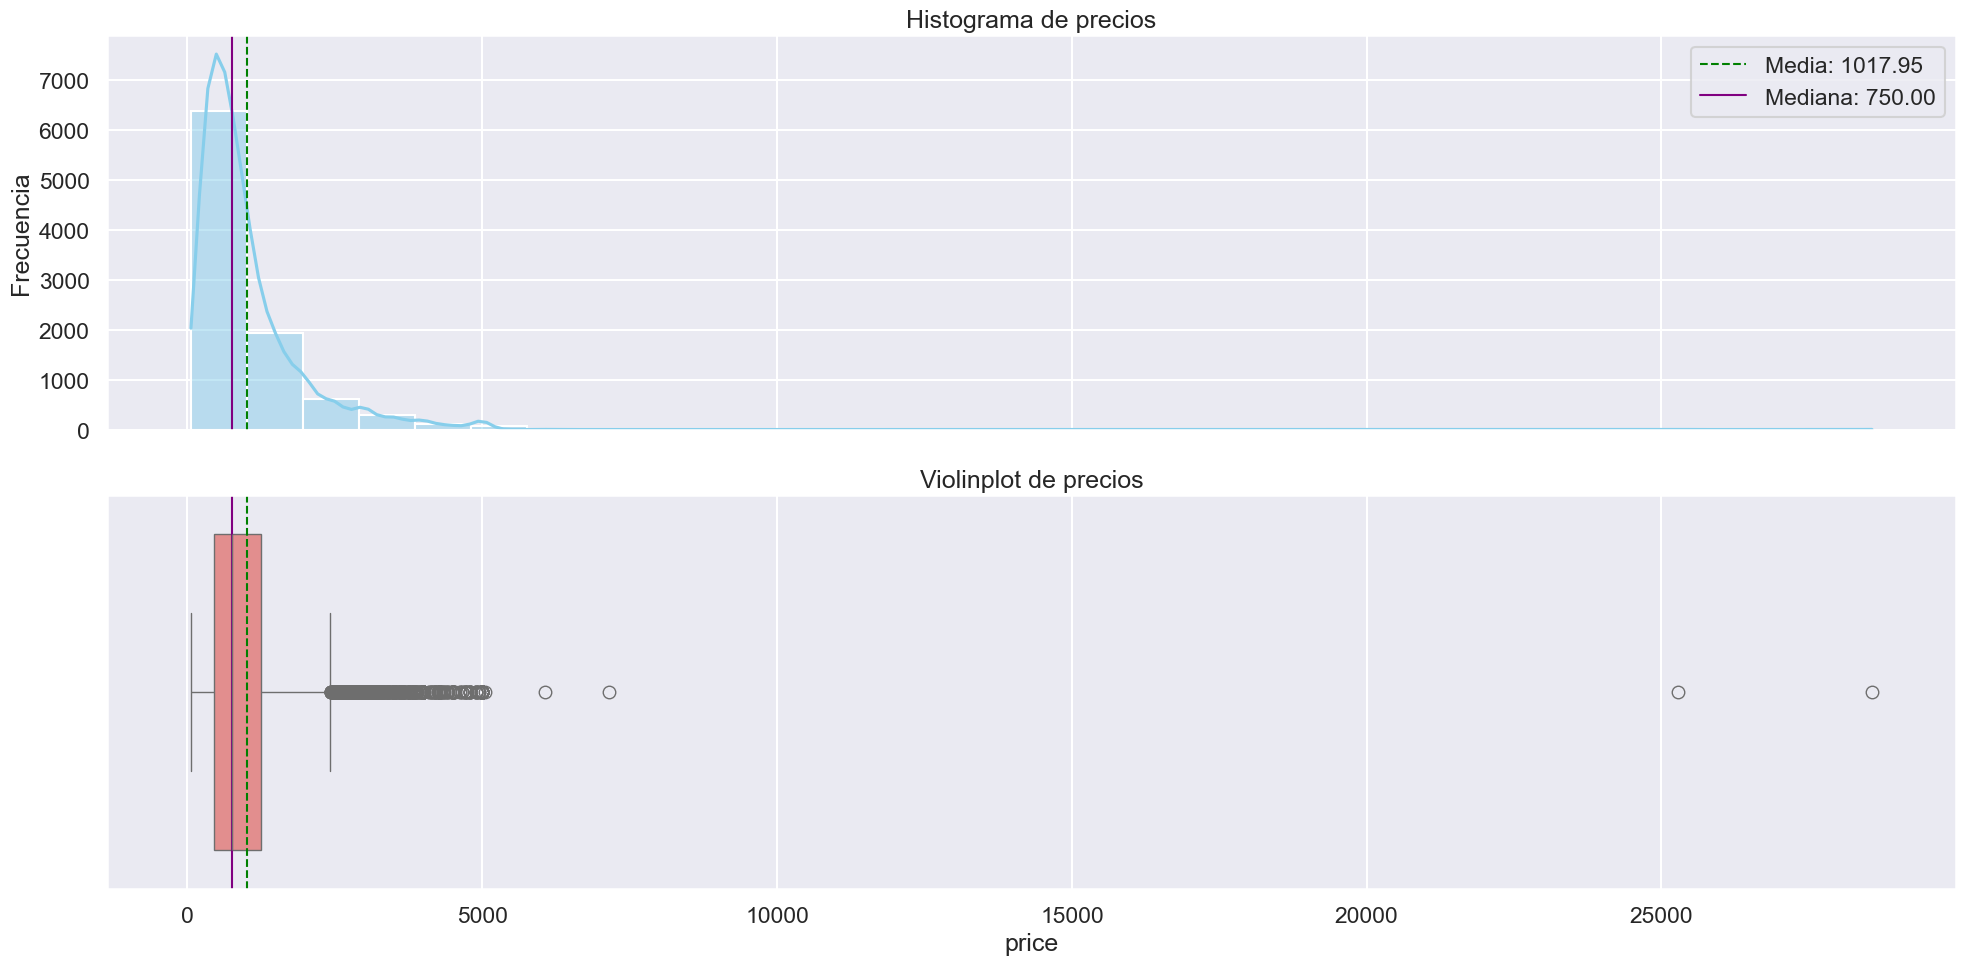

La media es de 1017.95 €, mientras tanto la mediana es de 750.00 €.

Estos son los 5 mayores outliers que tenemos:
9537    28571.0
9647    25286.0
9269     7143.0
2390     6071.0
4486     5043.0
Name: price, dtype: float64


In [17]:
media_precio = df['price'].mean()
mediana_precio = df['price'].median()

sns.set_theme(context='talk', style='darkgrid')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

sns.histplot(df['price'].dropna(), bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].axvline(media_precio, color='green', linestyle='--', linewidth=1.5, label=f'Media: {media_precio:.2f}')
axes[0].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5, label=f'Mediana: {mediana_precio:.2f}')
axes[0].set_title('Histograma de precios')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()

sns.boxplot(x=df['price'].dropna(), ax=axes[1], color='lightcoral')
axes[1].axvline(media_precio, color='green', linestyle='--', linewidth=1.5)
axes[1].axvline(mediana_precio, color='purple', linestyle='-', linewidth=1.5)
axes[1].set_title('Violinplot de precios')

plt.tight_layout()
plt.show()

outliers = df['price'].sort_values(ascending=False).head(5)
print(f'La media es de {media_precio:.2f} €, mientras tanto la mediana es de {mediana_precio:.2f} €.\n')
print(f'Estos son los 5 mayores outliers que tenemos:\n{outliers}')

In [18]:
df.nlargest(5, 'price')

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,amenities_normalized
9537,41372147,"VILLA VERD, nice villa in the country.","Villa Verd is a beautiful country house, finis...",313785862,Alc�dia,NaN,Entire home/apt,6,2,3,...,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,mallorca,2020-08-28,"air conditioning, baby essentials, bathroom es..."
9647,42188834,Roman Room by Hotel Mam�,<b>The space</b><br />Looks like a small cinem...,333351874,Palma de Mallorca,NaN,Private room,2,1,1,...,NaN,NaN,NaN,NaN,VERDADERO,NaN,spain,mallorca,2020-08-28,"air conditioning, bathroom essentials, bathroo..."
9269,39350327,2 habitaciones y Ba�o privado en Barrio Salamanca,Brand new floor (daylight basement) with 2 roo...,13669384,Fuente del Berro,Salamanca,Private room,4,1,2,...,100.0,100.0,100.0,100.0,VERDADERO,74.0,spain,madrid,2020-09-13,"air conditioning, baby essentials, bathroom es..."
2390,12970898,APARTAMENTO CENTRICO-EL CARMEN,Apartamento totalmente reformado en 2018. Dos ...,71363084,LA XEREA,CIUTAT VELLA,Entire home/apt,6,2,3,...,100.0,100.0,100.0,90.0,FALSO,122.0,spain,valencia,2020-09-28,"24-hour check-in, air conditioning, balcony, b..."
4486,19176730,Bello apartamento con terraza centro /Aire Acon.,Apartamento grande con capacidad para 5 person...,37406182,MORVEDRE,LA SAIDIA,Entire home/apt,5,2,2,...,100.0,100.0,100.0,90.0,FALSO,94.0,spain,valencia,2020-08-30,"air conditioning, balcony, bathroom essentials..."


### Imputación
En este contexto, imputar por la media no sería lo ideal porque se vería muy influenciada por outliers.   
Por lo que optamos por imputar usando la mediana por ciudad, tipo de habitación y accomodates. Esto es simple pero efectivo.

In [19]:
df['price'] = df.groupby(['city', 'room_type', 'accommodates'])['price'].transform(
    lambda x: x.fillna(x.median()))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out

In [20]:
print(f'Hay {df["price"].isnull().sum()} precios con valores nulos')

Hay 6 precios con valores nulos


##### Filtramos los registros que siguen teniendo precios con valores nulos, y veremos que combinaciones no se pudieron imputar.

In [21]:
faltantes = df[df['price'].isnull()]

print(faltantes[['city', 'room_type', 'accommodates']].drop_duplicates())

          city        room_type  accommodates
5459  mallorca  Entire home/apt            18
6756    madrid       Hotel room             4
4588   menorca  Entire home/apt            16
3247  mallorca  Entire home/apt            29
6234  mallorca  Entire home/apt            20
7675  mallorca  Entire home/apt            24


Si después de la primera ejecucion siguen habiendo valores nulos se realizará una segunda con una agrupación más general (no se tomara en cuenta capacidad, solo ciudad y tipo de habitacion).

In [22]:
df['price'] = df.groupby(['city', 'room_type'])['price'].transform(
    lambda x: x.fillna(x.median()))

##### Segunda comprobación

In [23]:
print(f"Hay {df['price'].isnull().sum()} precios con valores nulos")

Hay 0 precios con valores nulos


# EDA's 

### EDA Operaciones

#### Funciones 

Función de generación de gráficos EDA Operaciones

In [24]:
def generar_graficos_disponibilidad(df):
    
    # Calcular la media de disponibilidad por ciudad
    disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()

    # Calcular el porcentaje de disponibilidad respecto al total de días posibles (30, 60, 90, 365)
    disponibilidad_media_porcentaje = disponibilidad_media.copy()

    # Calcular el porcentaje para cada columna de disponibilidad
    disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
    disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
    disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
    disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

    # Definir una paleta de colores coherente y con buen contraste para los gráficos
    colores = sns.color_palette("Set2", 4)  # Usamos una paleta de colores más saturados y contrastantes

    # Mostrar la media de disponibilidad por ciudad
    print("Media de disponibilidad por ciudad\n")
    print(disponibilidad_media)

    # Mostrar la media de disponibilidad en porcentaje por ciudad
    print("\nMedia de disponibilidad en porcentaje por ciudad\n")
    print(disponibilidad_media_porcentaje)

Funcion de distribución de la disponibilidad en los distintos períodos boxplot

In [25]:
def distribucion_disponibilidadboxplot(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.boxplot(data=disponibilidad, color=colores[i], ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Días Disponibles', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de  distribución de la disponibilidad en los distintos períodos barras

In [26]:
def distribucion_disponibilidadbarras(df, colores):
    # Crear la figura y la cuadrícula de subgráficos (2x2)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas
    
    # Lista de períodos de disponibilidad
    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]
    
    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)
        
        # Seleccionar el eje correspondiente en la cuadrícula
        sns.histplot(disponibilidad, kde=True, color=colores[i], bins=30, ax=ax[fila, columna])
        
        # Añadir título y etiquetas
        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
        ax[fila, columna].set_ylabel('Frecuencia', fontsize=10)
    
    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de mini gráficos para cada categoría de disponibilidad

In [27]:
def mini_graficos_categoria(disponibilidad_media, colores):
    # Segunda parte: Mini gráficos para cada categoría de disponibilidad (sin porcentajes)
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # 2 filas, 2 columnas

    # Lista de categorías
    categorias = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

    for i, categoria in enumerate(categorias):
        fila = i // 2  # 0 o 1 (primera o segunda fila)
        columna = i % 2  # 0 o 1 (primera o segunda columna)

        ax_sub = ax[fila, columna]
        # Para cada categoría, mostrar la disponibilidad media sin porcentajes
        disponibilidad_media[categoria].plot(kind='bar', ax=ax_sub, width=0.8, color=colores[i])

        ax_sub.set_title(f'Disponibilidad Media {categoria}', fontsize=12)
        ax_sub.set_xlabel('Ciudad', fontsize=10)
        ax_sub.set_ylabel(f'Media {categoria}', fontsize=10)
        ax_sub.set_xticklabels(disponibilidad_media.index, rotation=45, ha='right')

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion para cada ciudad con disponibilidad media en porcentaje

In [28]:
def graficos_por_ciudad(disponibilidad_media_porcentaje, colores):
    # Tercera parte: Gráficos de barras para cada ciudad con la disponibilidad media en porcentaje
    
    # Determinar el número de filas y columnas en la cuadrícula (4x4)
    num_ciudades = len(disponibilidad_media_porcentaje)
    filas = 2
    columnas = 4
    
    # Crear la figura y la cuadrícula de subgráficos
    fig, ax = plt.subplots(filas, columnas, figsize=(20, 10))  # Ajustamos el tamaño de la figura
    
    # Convertir la matriz de ejes en una lista para poder iterar sobre ella
    ax = ax.flatten()
    
    for i, ciudad in enumerate(disponibilidad_media_porcentaje.index):
        # Extraer los valores de disponibilidad para la ciudad
        ciudad_data = disponibilidad_media_porcentaje.loc[ciudad]

        # Seleccionar el eje correspondiente en la cuadrícula
        ax[i].bar(ciudad_data.index, ciudad_data.values, color=colores, width=0.8)

        # Añadir título y etiquetas
        ax[i].set_title(f'Disponibilidad Media (%)\npor Ciudad: {ciudad}', fontsize=12)
        ax[i].set_xlabel('Periodo (días)', fontsize=10)
        ax[i].set_ylabel('Disponibilidad Media (%)', fontsize=10)

        # Ajustar las etiquetas del eje X automáticamente
        ax[i].tick_params(axis='x', rotation=45)

        # Establecer los límites de los ejes
        ax[i].set_ylim(0, 100)  # Limitar el eje Y de 0 a 100
        ax[i].set_xlim(-0.5, 3.5)  # Limitar el eje X de 0 a 3 (porque tenemos 4 barras)

    # Ajustar el diseño para una mejor visualización
    plt.tight_layout()
    plt.show()

Funcion de las medias de todas las ciudades

In [29]:
def grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores):
    # Última parte: Gráfico de las medias de todas las ciudades
    plt.figure(figsize=(12, 8))
    disponibilidad_media_porcentaje.plot(kind='bar', figsize=(12, 8), color=colores)
    plt.title('Disponibilidad Media (%) de los Alojamientos Turísticos por Ciudad')
    plt.xlabel('Ciudad')
    plt.ylabel('Disponibilidad Media (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#### Graficos

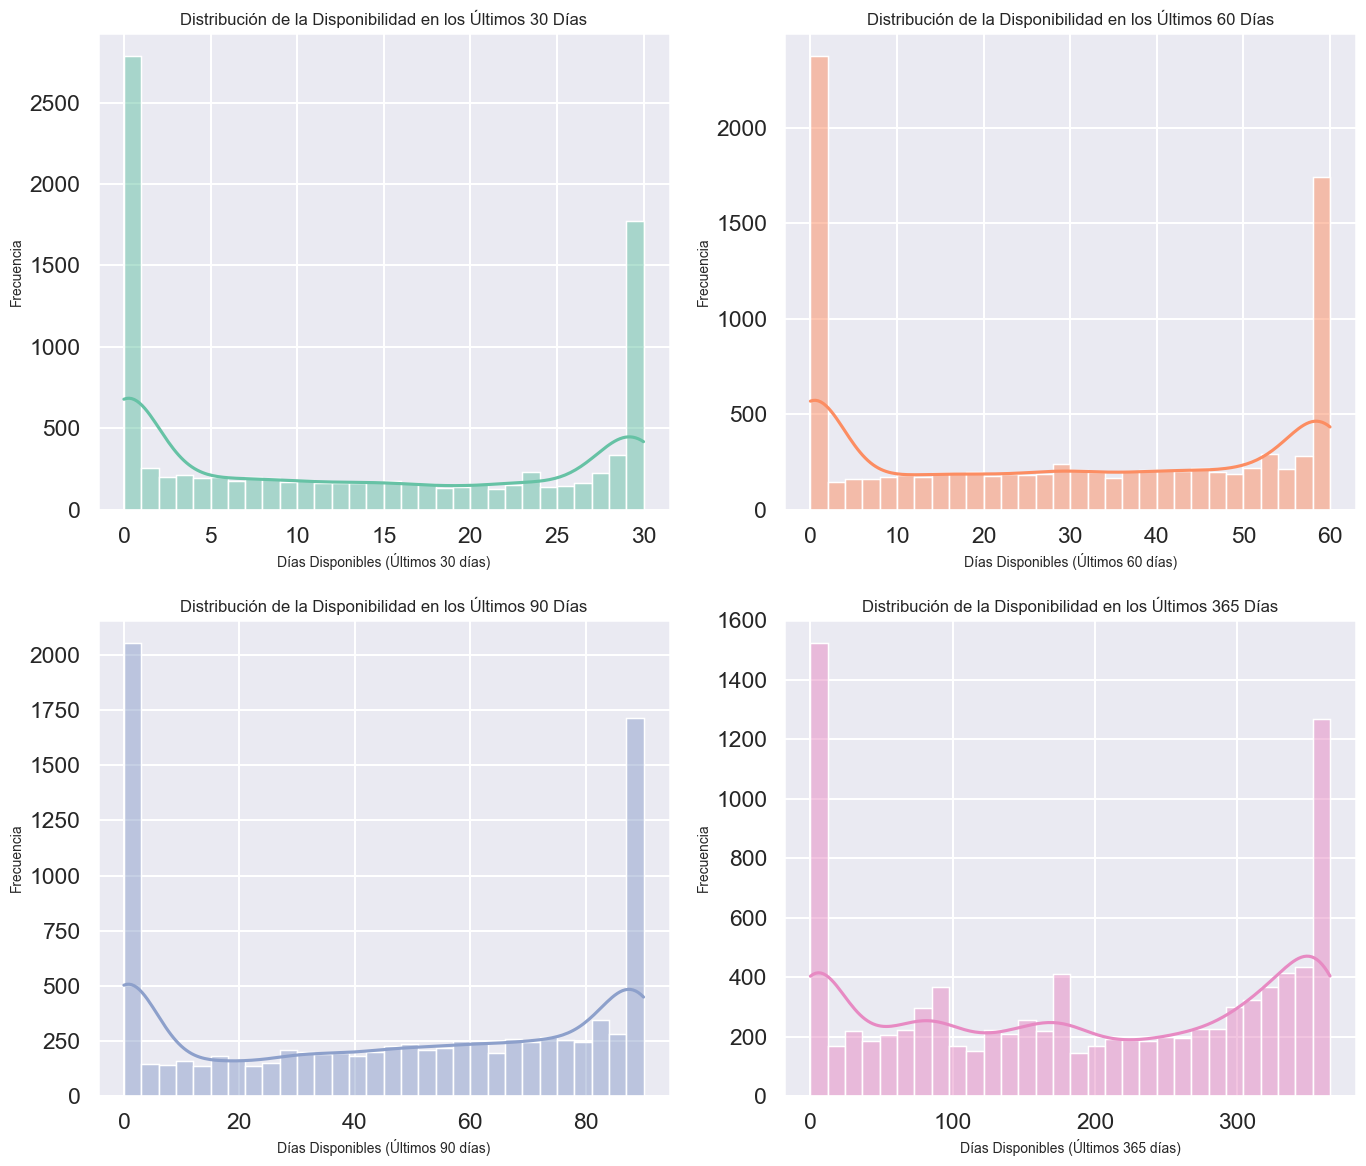

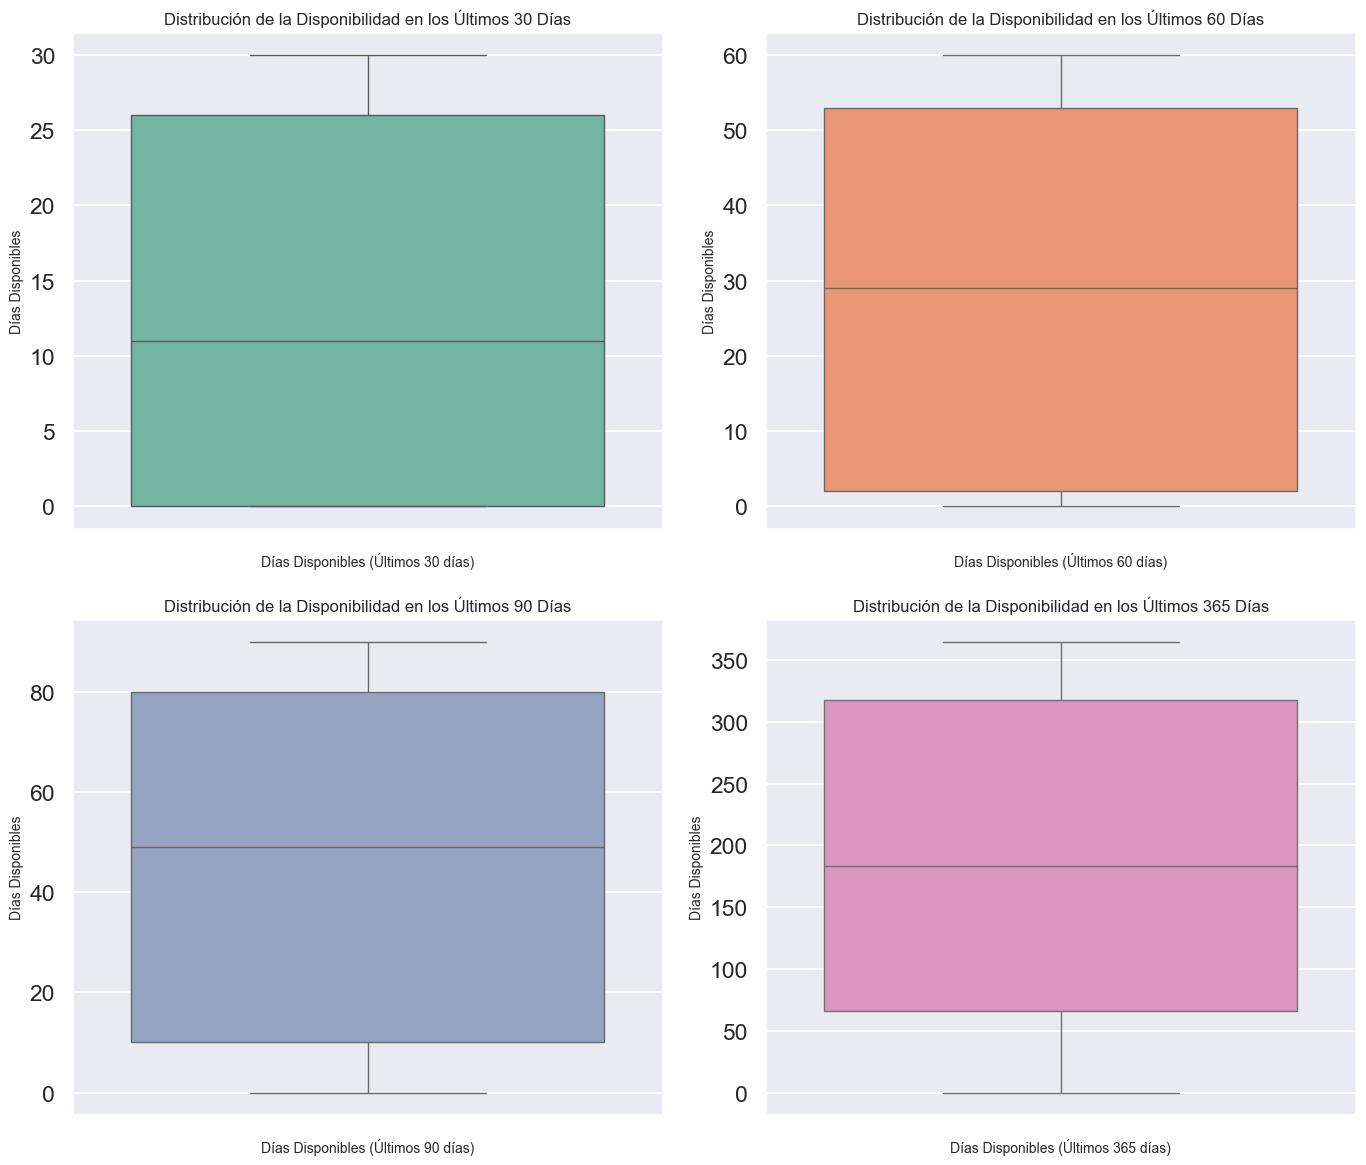

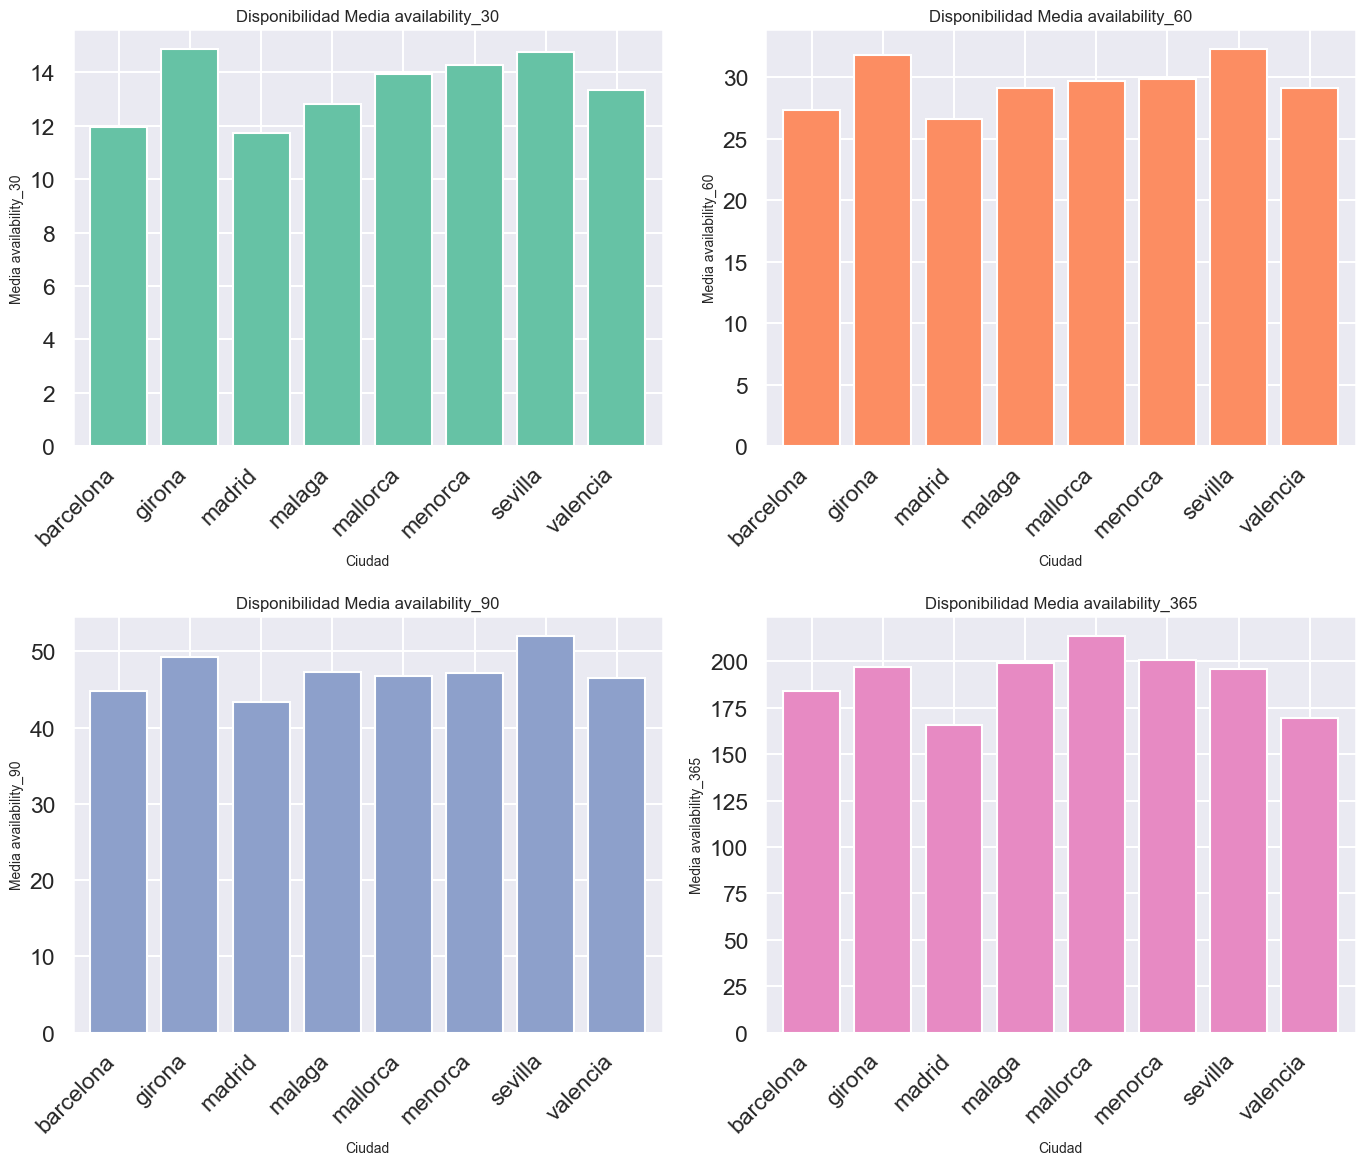

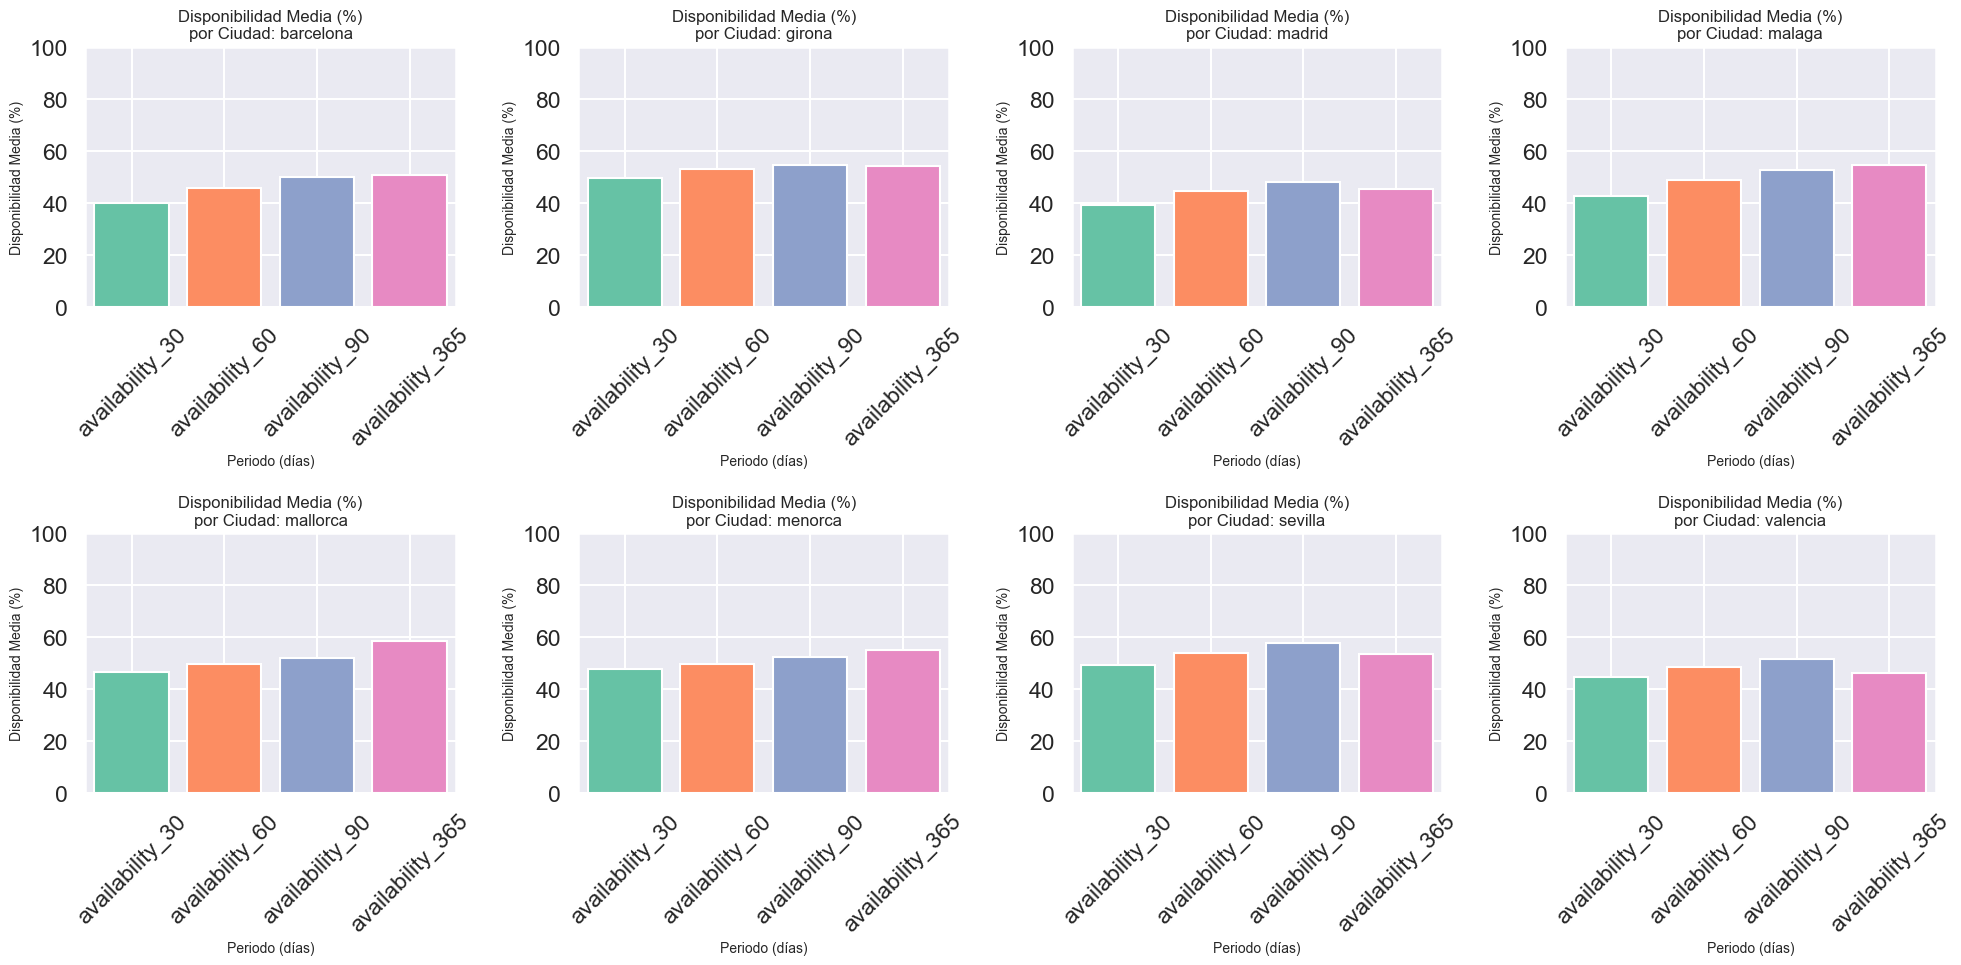

<Figure size 1200x800 with 0 Axes>

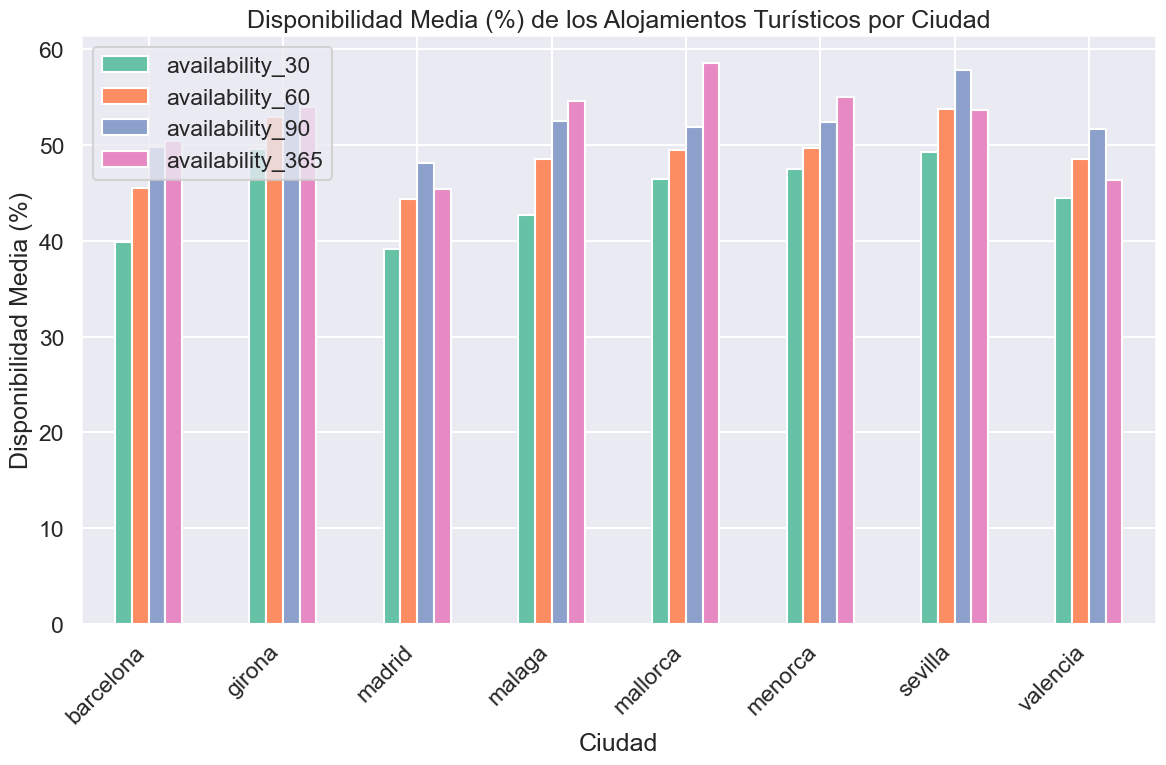

In [30]:
# Primero, calcular los porcentajes y la media
disponibilidad_media = df.groupby('city')[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean()
disponibilidad_media_porcentaje = disponibilidad_media.copy()

# Calcular los porcentajes para cada columna
disponibilidad_media_porcentaje['availability_30'] = (disponibilidad_media['availability_30'] / 30) * 100
disponibilidad_media_porcentaje['availability_60'] = (disponibilidad_media['availability_60'] / 60) * 100
disponibilidad_media_porcentaje['availability_90'] = (disponibilidad_media['availability_90'] / 90) * 100
disponibilidad_media_porcentaje['availability_365'] = (disponibilidad_media['availability_365'] / 365) * 100

# Definir la paleta de colores
colores = sns.color_palette("Set2", 4)

# Llamar las funciones para generar los gráficos
distribucion_disponibilidadbarras(df, colores)
distribucion_disponibilidadboxplot(df, colores)
mini_graficos_categoria(disponibilidad_media, colores)
graficos_por_ciudad(disponibilidad_media_porcentaje, colores)
grafico_media_todas_las_ciudades(disponibilidad_media_porcentaje, colores)

### EDA Clientes

#### Analisis descriptivo

In [31]:
df[['apartment_id', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month','city']].describe(include='all')

,apartment_id,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,city
count,9.650000e+03,7103,7102,7001.000000,6992.000000,6998.000000,6987.000000,6996.000000,6986.000000,6986.000000,7103.000000,9650
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,barcelona
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2719
mean,2.122473e+07,2017-06-15 22:58:10.018301952,2019-01-10 13:10:09.293156864,919.011570,94.486556,93.118034,96.221554,96.200686,95.415116,91.377040,123.703224,NaN
min,1.196400e+04,2010-01-02 00:00:00,2012-11-17 00:00:00,200.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,1.000000,NaN
25%,1.332096e+07,2016-06-17 00:00:00,2018-06-09 06:00:00,890.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,18.000000,NaN
50%,2.065612e+07,2017-08-08 00:00:00,2019-04-02 12:00:00,940.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.000000,58.000000,NaN
75%,3.016933e+07,2018-09-20 00:00:00,2019-10-29 00:00:00,980.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,177.000000,NaN
max,4.806155e+07,2021-01-17 00:00:00,2021-02-21 00:00:00,1000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1291.000000,NaN


##### Cantidad de apartamentos sin reseñas

In [32]:
sin_reseñas = df['first_review_date'].isna().sum()
print(f"Número de apartamentos sin reseñas: {sin_reseñas}")

Número de apartamentos sin reseñas: 2547


##### Porcentaje de apartamentos del total


In [33]:
porcentaje_sin_reseñas = (sin_reseñas / len(df)) * 100
print(f"Porcentaje de apartamentos sin reseñas: {porcentaje_sin_reseñas:.2f} %")

Porcentaje de apartamentos sin reseñas: 26.39 %


In [34]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = valores_unicos - sin_reseñas,
    domain = {'x': [0.1, 1], 'y': [0, 1]},
    title = {'text': "Apartamentos con reseñas"},
    delta = {'reference': valores_unicos},
    gauge = {
        'axis': {'range': [None, valores_unicos]},
        'steps': [
            {'range': [0, valores_unicos - sin_reseñas], 'color': "white"},
            {'range': [valores_unicos - sin_reseñas, valores_unicos], 'color': "lightgray"}]}))
fig.update_layout(autosize = False)

fig.show()

In [35]:
top_apartamentos_puntos = df.sort_values(['review_scores_rating', 'number_of_reviews'], ascending=False)
top_apartamentos_puntos.head(10)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,amenities_normalized
2218,11989301,Vivienda San Mart�n II,Rel�jate y desconecta mientras la c�lida luz v...,34840363,SANT FRANCESC,CIUTAT VELLA,Entire home/apt,4,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,394.0,spain,valencia,2019-12-31,"24-hour check-in, air conditioning, baby essen..."
1783,9122183,Casa sevillana en barrio historico,Habitaci�n luminosa con terraza privada para u...,47528412,Pio XII,Macarena,Private room,2,2,1,...,100.0,100.0,90.0,100.0,FALSO,347.0,spain,sevilla,2019-07-29,"24-hour check-in, air conditioning, bathroom e..."
5759,22979863,"Stylish Apt PZA MAYOR/La Latina 2BD* 2BT*, 6p max","Cozy and well-designed 2 bedroom apartment, co...",29281033,Palacio,Centro,Entire home/apt,6,2,2,...,100.0,100.0,100.0,100.0,VERDADERO,376.0,spain,madrid,2021-01-12,"24-hour check-in, air conditioning, baby essen..."
6072,23782265,Romantic and Rustic Penthouse with a Sun Kisse...,Marvel at an adorable cottage-like space in an...,40929334,ARRANCAPINS,EXTRAMURS,Entire home/apt,2,1,1,...,100.0,100.0,100.0,90.0,VERDADERO,501.0,spain,valencia,2020-05-31,"air conditioning, balcony, bathroom essentials..."
5587,22479174,Private room in detached house,"Cozy private room in a detached villa, near Ad...",80975261,Rejas,San Blas - Canillejas,Private room,2,2,1,...,100.0,100.0,100.0,100.0,FALSO,327.0,spain,madrid,2020-08-25,"24-hour check-in, air conditioning, balcony, b..."
3365,16292600,BCN Luxury,Lujoso apartamento en pleno centro de Barcelon...,15944590,l'Antiga Esquerra de l'Eixample,Eixample,Entire home/apt,4,2,2,...,100.0,100.0,100.0,100.0,FALSO,274.0,spain,barcelona,2020-02-16,"24-hour check-in, air conditioning, baby essen..."
309,1073748,"MAGIC PLACE IN BARCELONA, WITH POOL",<b>The space</b><br />MAGIC PLACE IN BARCELONA...,5159312,"Vallvidrera, el Tibidabo i les Planes",Sarri�-Sant Gervasi,Entire home/apt,4,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,101.0,spain,barcelona,2020-11-06,"air conditioning, baby essentials, balcony, ba..."
3717,17384311,"Cubic House Garden, Cala Morlanda.",Cozy designer apartment located in a nice gar...,11087082,Manacor,NaN,Entire home/apt,3,1,1,...,100.0,100.0,90.0,100.0,VERDADERO,196.0,spain,mallorca,2020-10-21,"24-hour check-in, air conditioning, baby essen..."
5404,21916433,Typical majorcan house in Llucmajor,Cozy 2 floors family house with 5 double bedro...,159911693,Llucmajor,NaN,Entire home/apt,10,3,5,...,100.0,100.0,90.0,100.0,FALSO,314.0,spain,mallorca,2020-03-22,"air conditioning, balcony, bathroom essentials..."
5408,21925668,�tico con piscina Triana 2mm del Centro de sev...,Nous sommes � Triana � 2mm du centre de Sevill...,15589434,Triana Casco Antiguo,Triana,Entire home/apt,7,2,3,...,100.0,100.0,100.0,100.0,VERDADERO,514.0,spain,sevilla,2019-02-18,"24-hour check-in, air conditioning, baby essen..."


In [36]:
top_apartamentos_num_reviews = df.sort_values(['number_of_reviews', 'review_scores_rating'], ascending=False)
top_apartamentos_num_reviews.head(10)

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,is_instant_bookable,reviews_per_month,country,city,insert_date,amenities_normalized
63,384727,Private Room in Center of Seville,"located in the centre of Seville, offers accom...",1920069,Arenal,Casco Antiguo,Private room,2,1,1,...,100.0,100.0,100.0,100.0,FALSO,681.0,spain,sevilla,2019-06-29,"24-hour check-in, air conditioning, bathroom e..."
264,959840,PL REAL (Sq) PENTHOUSE Rooftop,"Rustic penthous with old beams,old ceramic flo...",5223863,el Barri G�tic,Ciutat Vella,Private room,2,2,1,...,100.0,100.0,100.0,100.0,VERDADERO,71.0,spain,barcelona,2019-12-10,"24-hour check-in, air conditioning, balcony, b..."
511,1871218,�tico apartamento VFT/SE/00804,"�tico muy luminoso. Consta de: Sal�n, Ba�o, Co...",9751847,"Le�n XIII, Los Naranjos",Macarena,Entire home/apt,2,1,1,...,100.0,100.0,90.0,80.0,VERDADERO,698.0,spain,sevilla,2020-01-30,"air conditioning, balcony, bathroom essentials..."
729,3058631,"Private Studio in Sol, Madrid","We are offering a clean, well presented and re...",14370747,Sol,Centro,Entire home/apt,3,1,1,...,100.0,100.0,100.0,90.0,FALSO,698.0,spain,madrid,2020-07-17,"24-hour check-in, air conditioning, bathroom e..."
98,526513,Sol. Your home in Madrid�s Heart,DESIGN apartment in the HEART of Madrid.<br />...,1134989,Sol,Centro,Entire home/apt,5,1,2,...,100.0,100.0,100.0,100.0,VERDADERO,491.0,spain,madrid,2021-01-12,"24-hour check-in, air conditioning, baby essen..."
753,3143400,Great room in the center of Madrid,"Bright room in hortaleza Street, next to Gran ...",15328893,Justicia,Centro,Private room,2,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,773.0,spain,madrid,2020-10-17,"air conditioning, balcony, bathroom essentials..."
145,681925,"Very Central, Stunning Views, Sunny Terrace, W...",FANTASTIC PENTHOUSE LOCATED IN THE CENTER OF V...,3462415,EL PILAR,CIUTAT VELLA,Entire home/apt,2,1,1,...,100.0,100.0,100.0,100.0,VERDADERO,624.0,spain,valencia,2019-05-31,"24-hour check-in, air conditioning, balcony, b..."
478,1670427,Walk everywhere!Brand new apartWIFI,The apartment is right in the center of Barce...,8843962,la Dreta de l'Eixample,Eixample,Entire home/apt,5,1,1,...,100.0,100.0,100.0,90.0,VERDADERO,588.0,spain,barcelona,2020-10-12,"air conditioning, baby essentials, bathroom es..."
936,4028518,Renovated & Vintage en Barcelona,Welcome to this cozy apartment located in the ...,20886062,la Sagrada Fam�lia,Eixample,Entire home/apt,4,1,2,...,100.0,100.0,100.0,100.0,VERDADERO,712.0,spain,barcelona,2020-03-16,"24-hour check-in, air conditioning, baby essen..."
1313,6289283,Cozy apartment near El Raval,Nice bright room with large private terrace (p...,32695481,el Raval,Ciutat Vella,Private room,2,1,1,...,100.0,90.0,90.0,90.0,VERDADERO,78.0,spain,barcelona,2020-03-16,"24-hour check-in, air conditioning, balcony, b..."


#### Imputar fecha de inserción del registro para los casos en que hay reseñas y la last_review_date es nula


In [37]:
df.loc[df['last_review_date'].isna() & df['first_review_date'].notna(), 'last_review_date'] = df['insert_date']

Imputación de valoraciones en 122 registros mal ingresados

In [38]:
# Seleccionar las columnas relacionadas con reseñas
review_cols = [col for col in df.columns if 'scores' in col]

# Filtrar los registros que tienen fechas de reseña pero valores nulos en columnas de review
mask_nulos = (
    df['first_review_date'].notnull() &
    df['last_review_date'].notnull() &
    df[review_cols].isnull().any(axis=1)
)

df_reviews_to_impute = df.loc[mask_nulos, review_cols]

print(f"Número de registros a imputar: {df_reviews_to_impute.shape[0]}")


Número de registros a imputar: 122


In [39]:
context_cols = [
    'number_of_reviews', 'reviews_per_month',
    'room_type', 'minimum_nights', 'availability_365',
    'price', 'first_review_date', 'last_review_date'
]

# 2. Crear copia para modelado
df_model = df[review_cols + context_cols].copy()

# 3. Convertir fechas a datetime
df_model['first_review_date'] = pd.to_datetime(df_model['first_review_date'], errors='coerce')
df_model['last_review_date'] = pd.to_datetime(df_model['last_review_date'], errors='coerce')

# 4. Crear variables numéricas basadas en fechas
today = pd.to_datetime('today')
df_model['days_since_first_review'] = (today - df_model['first_review_date']).dt.days
df_model['days_since_last_review'] = (today - df_model['last_review_date']).dt.days
df_model['review_lifespan'] = (df_model['last_review_date'] - df_model['first_review_date']).dt.days

# 5. Eliminar columnas datetime originales
df_model = df_model.drop(columns=['first_review_date', 'last_review_date'])

# 6. Codificar variables categóricas
df_model = pd.get_dummies(df_model, columns=['room_type'], drop_first=True)

# 7. Filtrar registros con fechas de reseña (base para imputación)
mask = df['first_review_date'].notnull() & df['last_review_date'].notnull()

X = df_model.loc[mask, df_model.columns.difference(review_cols)]
y = df_model.loc[mask, review_cols]

# 8. Separar registros para entrenamiento y predicción
train_mask = y.notnull().all(axis=1)
X_train = X[train_mask]
y_train = y[train_mask]

pred_mask = y.isnull().any(axis=1)
X_pred = X[pred_mask]
pred_indices = y[pred_mask].index

# 9. Entrenar modelo Random Forest multisalida
model = MultiOutputRegressor(RandomForestRegressor(n_estimators=200, random_state=42))
model.fit(X_train, y_train)

# 10. Predecir valores nulos
y_pred = model.predict(X_pred)
y_pred = pd.DataFrame(y_pred, columns=review_cols, index=pred_indices)

# 11. Redondear puntuaciones a los múltiplos válidos
for col in review_cols:
    if col == 'review_scores_rating':
        y_pred[col] = (100 * np.round(y_pred[col] / 100)).clip(0, 1000)
    else:
        y_pred[col] = (10 * np.round(y_pred[col] / 10)).clip(0, 100)

# 12. Reemplazar valores nulos en el DataFrame original
df.loc[pred_indices, review_cols] = y_pred


Comprobamos los estadísticos tras la imputación

In [40]:
# EDA de Experiencia del Cliente

df[['apartment_id', 'first_review_date', 'last_review_date',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month','city']].describe(include='all')

,apartment_id,first_review_date,last_review_date,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,city
count,9.650000e+03,7103,7104,7103.000000,7103.000000,7103.000000,7103.000000,7103.000000,7103.000000,7103.000000,7103.000000,9650
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,barcelona
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2719
mean,2.122473e+07,2017-06-15 22:58:10.018301952,2019-01-10 09:38:18.648648960,919.020132,94.429114,93.109954,96.197381,96.172040,95.392088,91.351542,123.703224,NaN
min,1.196400e+04,2010-01-02 00:00:00,2012-11-17 00:00:00,200.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,1.000000,NaN
25%,1.332096e+07,2016-06-17 00:00:00,2018-06-09 00:00:00,890.000000,90.000000,90.000000,90.000000,90.000000,90.000000,90.000000,18.000000,NaN
50%,2.065612e+07,2017-08-08 00:00:00,2019-04-02 00:00:00,940.000000,100.000000,100.000000,100.000000,100.000000,100.000000,90.000000,58.000000,NaN
75%,3.016933e+07,2018-09-20 00:00:00,2019-10-29 00:00:00,980.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,177.000000,NaN
max,4.806155e+07,2021-01-17 00:00:00,2021-02-21 00:00:00,1000.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1291.000000,NaN


Validación de las imputaciones: validación cruzada

In [41]:
# Usar un solo estimador para validar una columna a la vez
mae_scores = []

for col in review_cols:
    y_col = y_train[col]
    scores = cross_val_score(
        RandomForestRegressor(n_estimators=200, random_state=42),
        X_train, y_col,
        scoring=make_scorer(mean_absolute_error),
        cv=5
    )
    print(f"MAE para {col}: {scores.mean():.2f}")
    mae_scores.append(scores.mean())

print(f"\nMAE promedio de todos los targets: {np.mean(mae_scores):.2f}")

MAE para review_scores_rating: 64.77
MAE para review_scores_accuracy: 6.97
MAE para review_scores_cleanliness: 7.59
MAE para review_scores_checkin: 5.83
MAE para review_scores_communication: 5.84
MAE para review_scores_location: 6.07
MAE para review_scores_value: 7.34

MAE promedio de todos los targets: 14.92


Validación de las imputaciones: GridSearchCV

In [42]:
from sklearn.model_selection import GridSearchCV

# Usamos solo una de las columnas objetivo para optimizar (p. ej. review_scores_rating)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Elegimos una columna representativa para afinar el modelo
grid_search.fit(X_train, y_train['review_scores_rating'])

print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)
print(f"MAE (negativo): {grid_search.best_score_:.2f}")


Mejores hiperparámetros encontrados:
{'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
MAE (negativo): -66.09


Visualizaciones

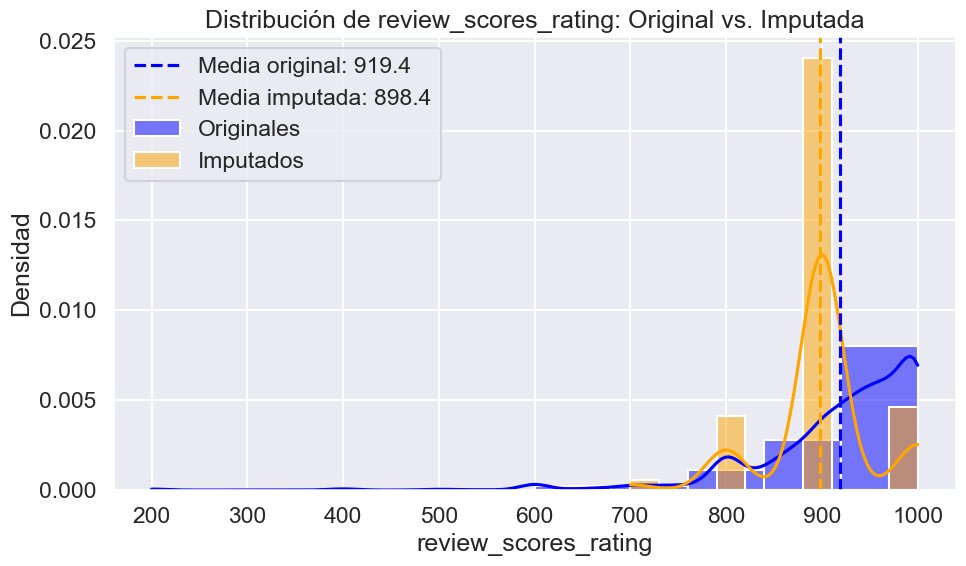

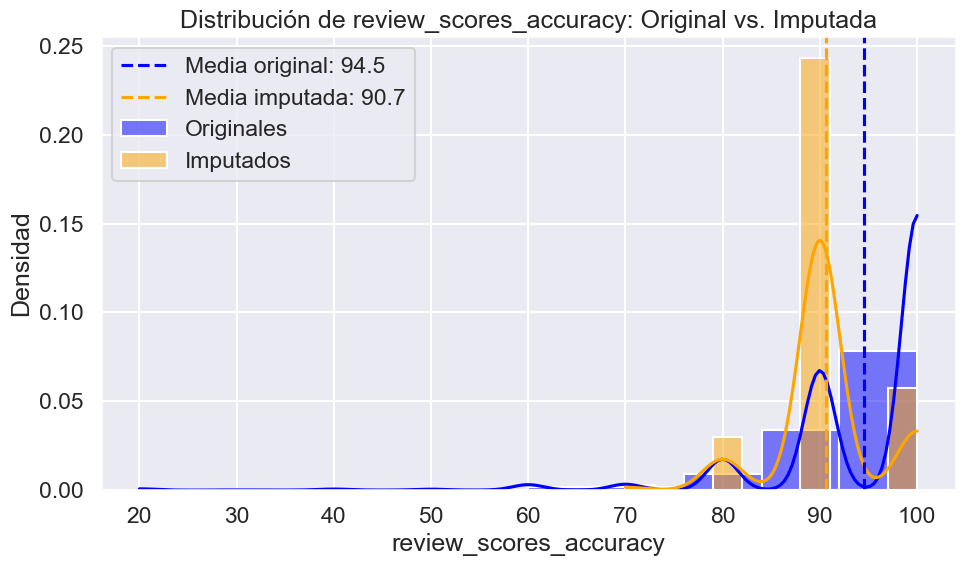

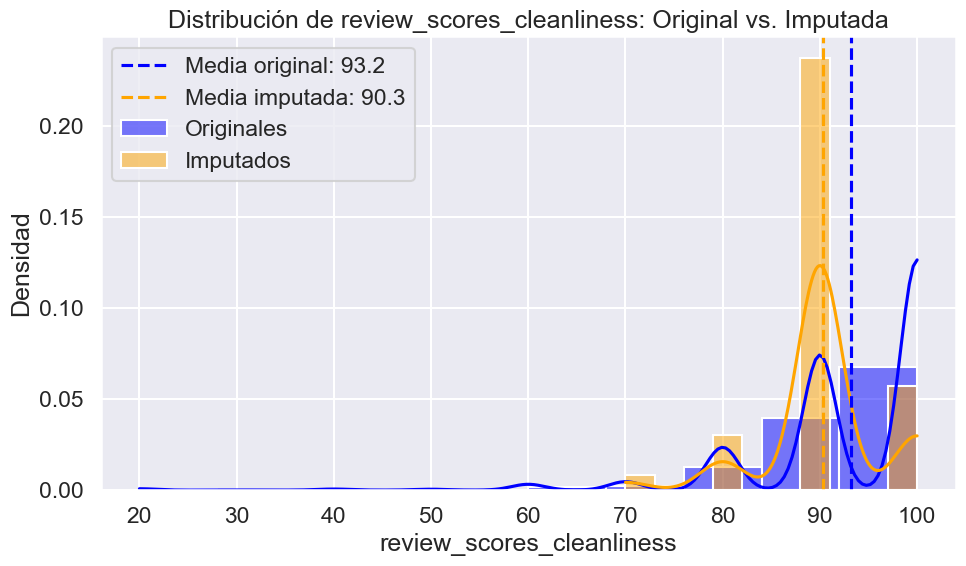

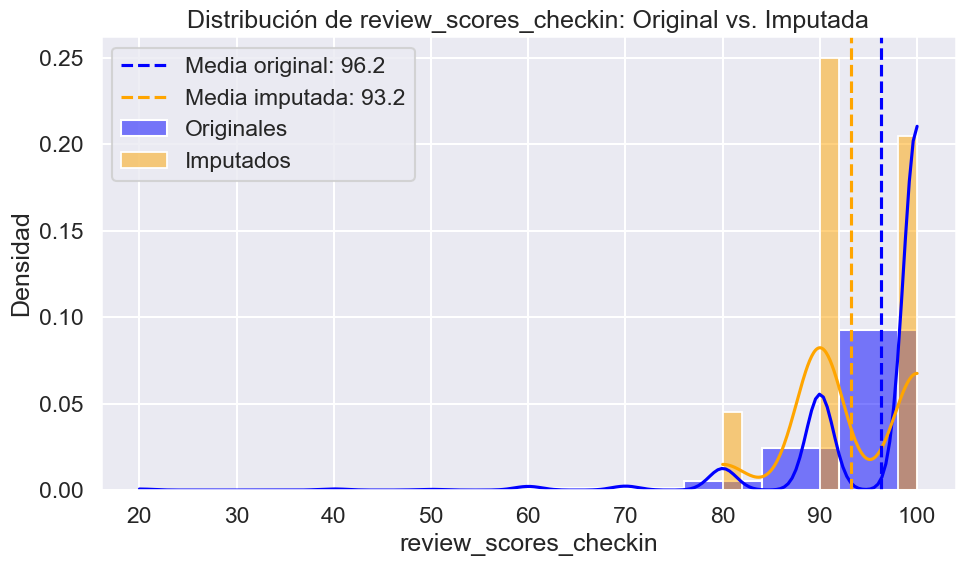

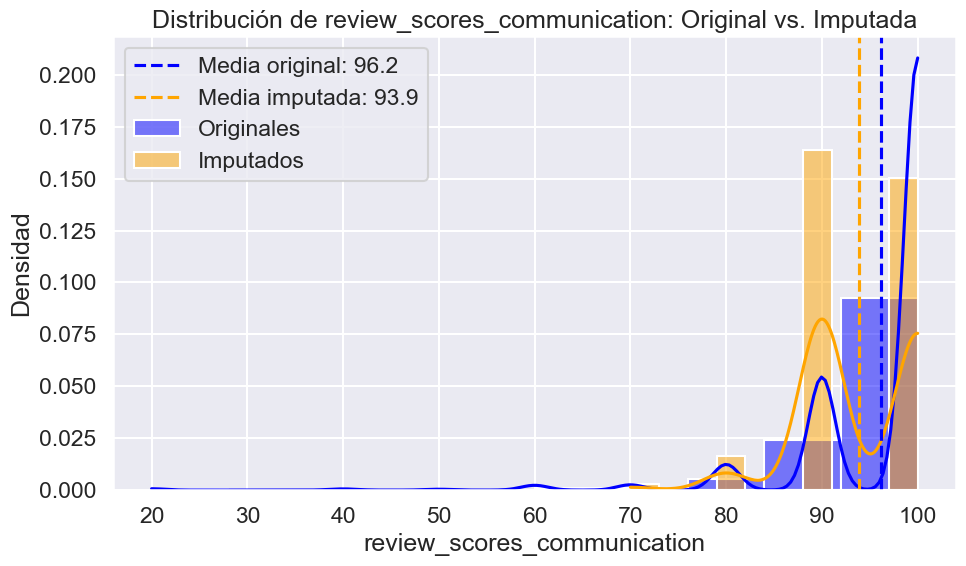

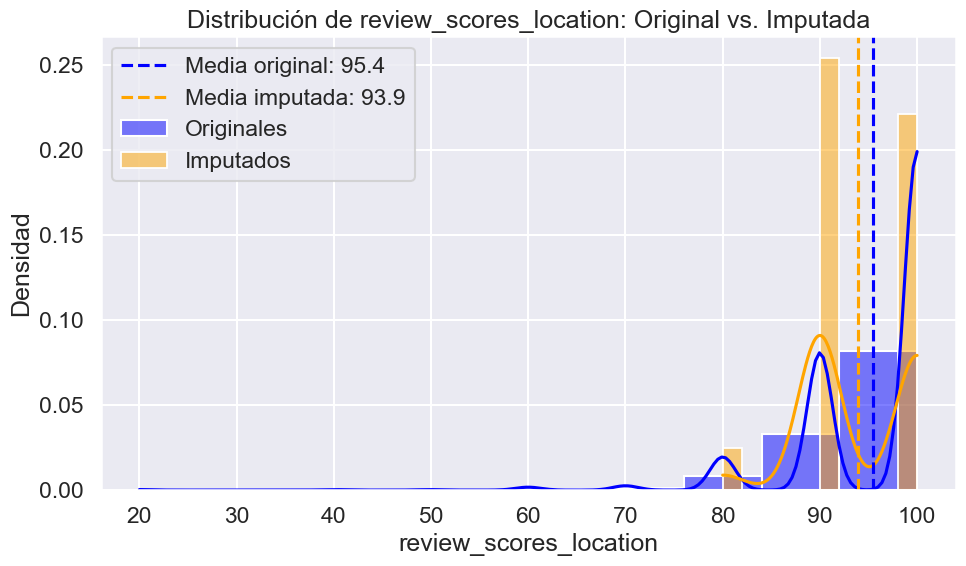

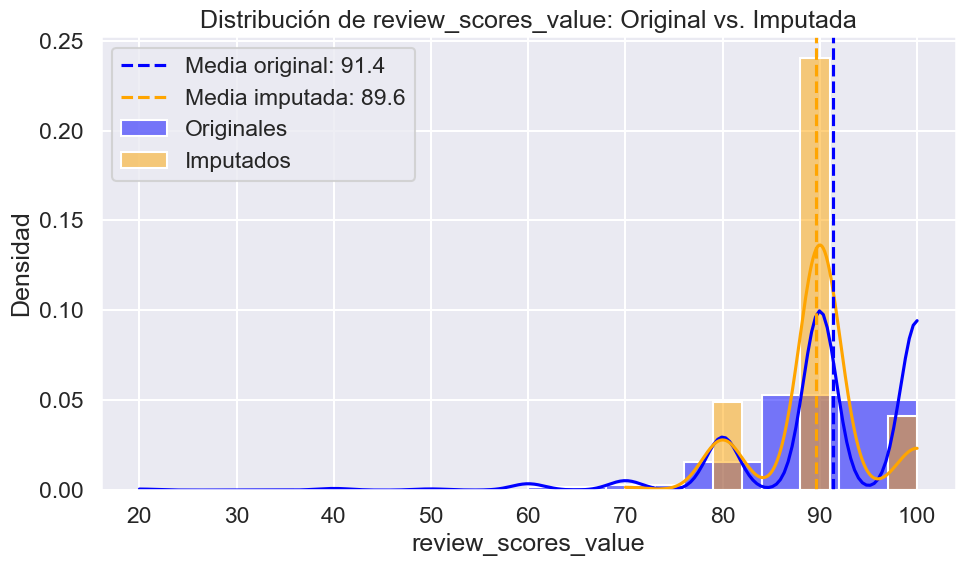

In [43]:
# 9. Visualizar distribución de una variable imputada
for col in review_cols:
    original = df.loc[~df.index.isin(y_pred.index), col]
    imputed = df.loc[y_pred.index, col]

    plt.figure(figsize=(10, 6))
    sns.histplot(original, bins=10, kde=True, color='blue', label='Originales', stat='density')
    sns.histplot(imputed, bins=10, kde=True, color='orange', label='Imputados', stat='density')
    plt.axvline(original.mean(), color='blue', linestyle='--', label=f"Media original: {original.mean():.1f}")
    plt.axvline(imputed.mean(), color='orange', linestyle='--', label=f"Media imputada: {imputed.mean():.1f}")
    plt.title(f'Distribución de {col}: Original vs. Imputada')
    plt.xlabel(col)
    plt.ylabel('Densidad')
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Graficos

##### Distribución de números de reviews

Text(0.5, 0, 'N.º de reseñas')

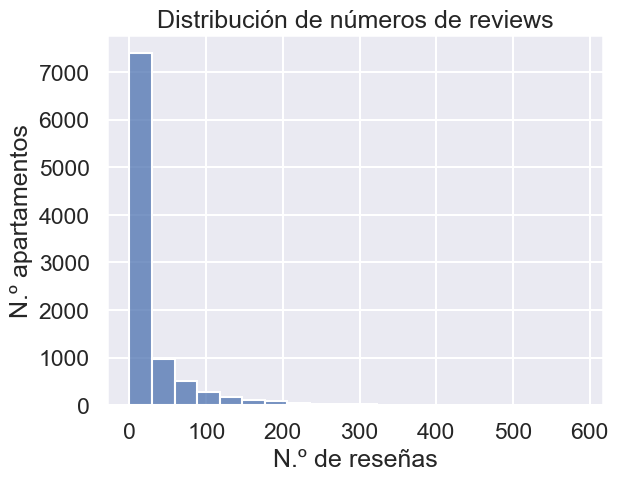

In [44]:
ax = sns.histplot(data=df, x='number_of_reviews', bins=20)
ax.set_title("Distribución de números de reviews")
ax.set_ylabel("N.º apartamentos")
ax.set_xlabel("N.º de reseñas")

##### Kde de distribución de reviews

Text(0.5, 0.98, 'Kde de distribución de reviews')

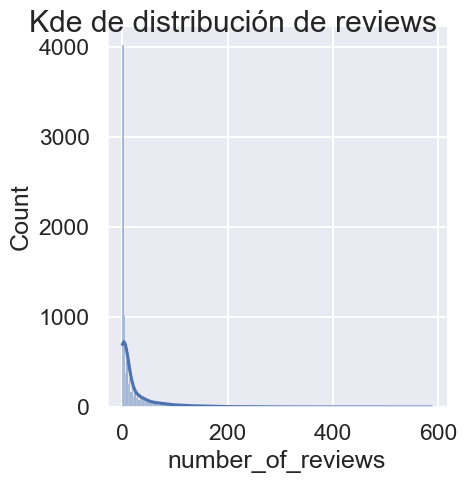

In [45]:
ax = sns.displot(data=df, x='number_of_reviews', kde=True)
ax.figure.suptitle("Kde de distribución de reviews")

##### Distribución estadística del rating total por ciudad

Text(0.5, 1.0, 'Distribución estadística del rating total por ciudad')

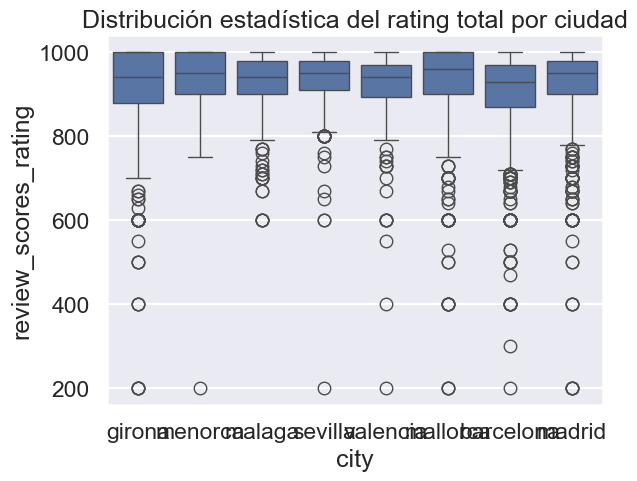

In [46]:
ax = sns.boxplot(data=df, x='city', y='review_scores_rating')
ax.set_title("Distribución estadística del rating total por ciudad")

##### Distribución estadística del rating total por tipo de alojamiento

Text(0.5, 1.0, 'Distribución estadística del rating total por tipo de alojamiento')

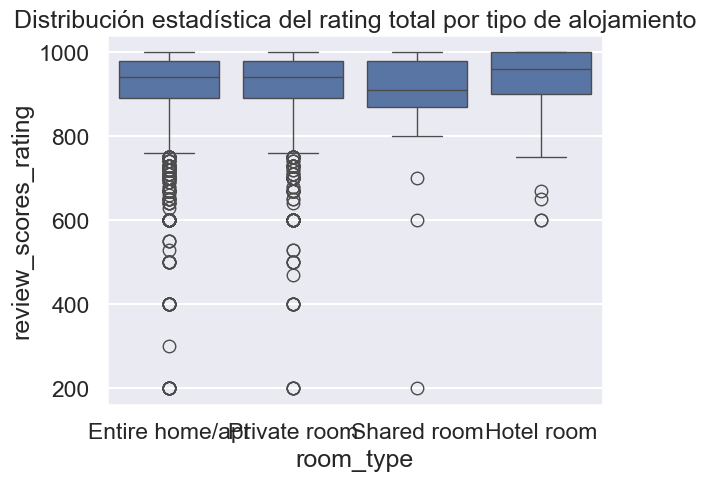

In [47]:
ax = sns.boxplot(data=df, x='room_type', y='review_scores_rating')
ax.set_title("Distribución estadística del rating total por tipo de alojamiento")

#### Frecuencia de reseñas al mes por puntuación

<Axes: xlabel='review_scores_value', ylabel='reviews_per_month'>

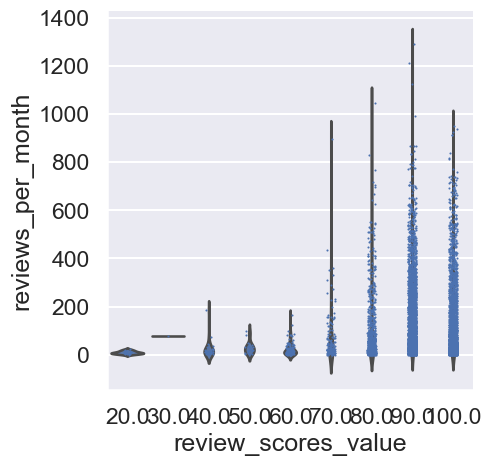

In [48]:
g = sns.catplot(data=df, x='review_scores_value', y='reviews_per_month', kind="violin", inner=None)
sns.stripplot(data=df, x='review_scores_value', y='reviews_per_month', color="b", size=1.5, ax=g.ax)

### EDA Marketing y comunicacion

#### Funciones


##### Función para añadir el símbolo € a los valores del eje

In [49]:
def euro_formatter(x, pos):
    return f"{x:,.0f}€"  # Format amb 0 

##### Función para formatear el eje y con separador de miles

In [50]:
def formato_miles(x, pos):
    return f'{int(x):,}'

##### Establecer paleta y estilo

In [51]:
sns.set_style("darkgrid")
sns.set_palette("tab10") 

#### Analisis Descriptivo

##### Variables numericas

In [52]:
print(df.describe()) 

       apartment_id       host_id  accommodates  bathrooms  bedrooms  \
count  9.650000e+03  9.650000e+03   9650.000000     9584.0    9583.0   
mean   2.122473e+07  9.097918e+07      4.266943   1.593176  1.936137   
min    1.196400e+04  1.070400e+04      1.000000        0.0       0.0   
25%    1.332096e+07  1.506455e+07      2.000000        1.0       1.0   
50%    2.065612e+07  6.569780e+07      4.000000        1.0       2.0   
75%    3.016933e+07  1.429782e+08      6.000000        2.0       3.0   
max    4.806155e+07  3.874783e+08     29.000000       13.0      50.0   
std    1.161793e+07  8.717279e+07      2.589438   0.989921   1.37625   

           beds         price  minimum_nights  maximum_nights  \
count    9605.0   9650.000000     9650.000000     9650.000000   
mean   2.922853   1035.132746        4.966839      759.591710   
min         0.0     60.000000        1.000000        1.000000   
25%         1.0    450.000000        1.000000       62.000000   
50%         2.0    750.000

##### Tipos de datos y variables nulas

In [53]:
print(df.info()) 

<class 'pandas.core.frame.DataFrame'>
Index: 9650 entries, 3092 to 2456
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   apartment_id                 9650 non-null   int64         
 1   name                         9647 non-null   object        
 2   description                  9514 non-null   object        
 3   host_id                      9650 non-null   int64         
 4   neighbourhood_name           9650 non-null   object        
 5   neighbourhood_district       5860 non-null   object        
 6   room_type                    9650 non-null   object        
 7   accommodates                 9650 non-null   int64         
 8   bathrooms                    9584 non-null   Int64         
 9   bedrooms                     9583 non-null   Int64         
 10  beds                         9605 non-null   Int64         
 11  amenities_list               9650 non-null   

#### Distribucion de precios

##### General

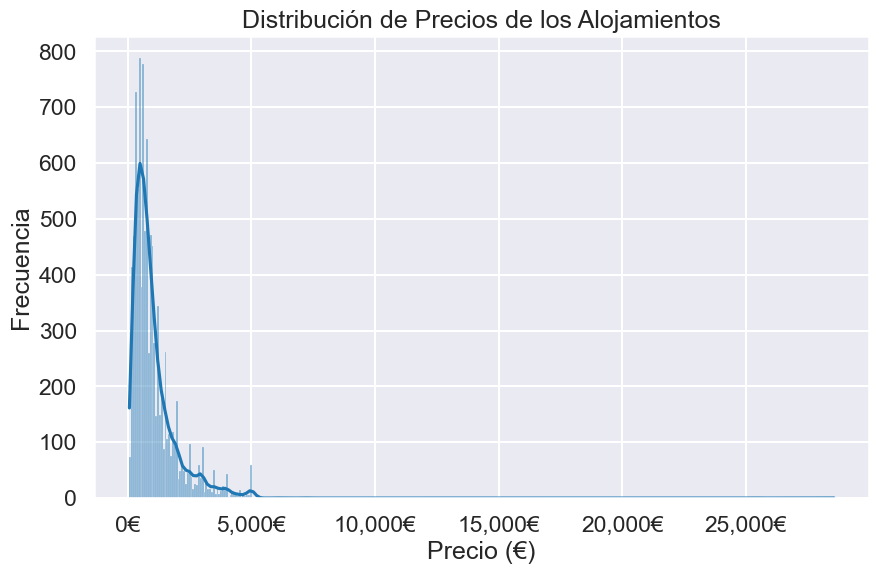

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(df['price'], kde=True) #, color='blue')
plt.title('Distribución de Precios de los Alojamientos')
plt.xlabel('Precio (€)')
plt.ylabel('Frecuencia')
# Aplicar el formatter al eje X para mostrar el símbolo €
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por ciudad

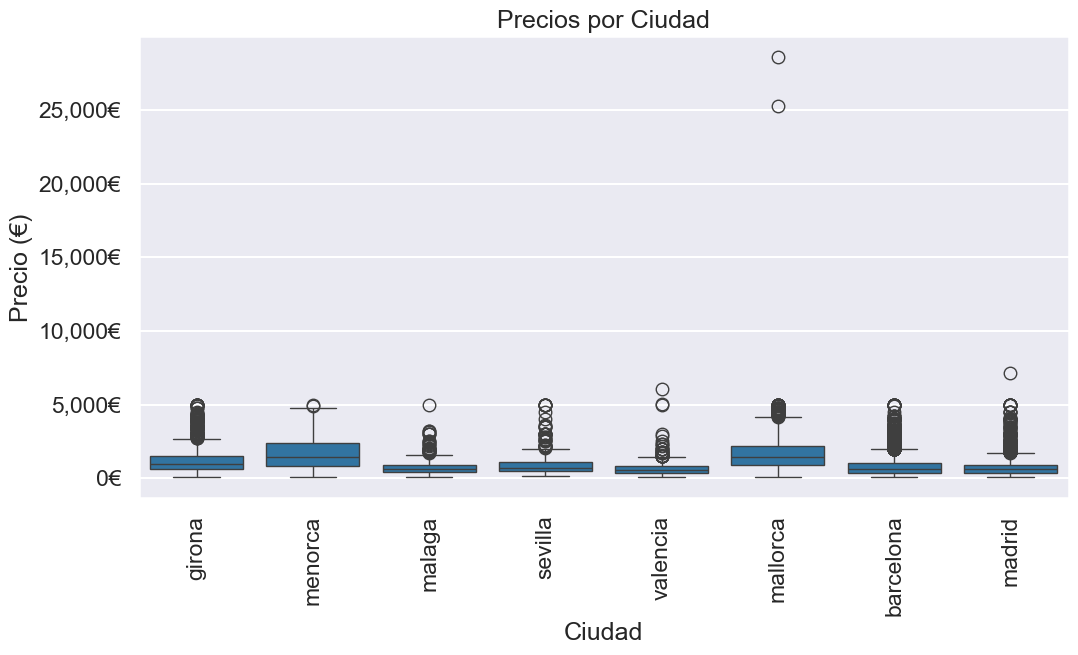

In [55]:
# Boxplot de precios por ciudad
plt.figure(figsize=(12, 6))
sns.boxplot(x='city', y='price', data=df)
plt.title('Precios por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.xticks(rotation=90)
plt.show()

##### Precios por tipo de alojamiento

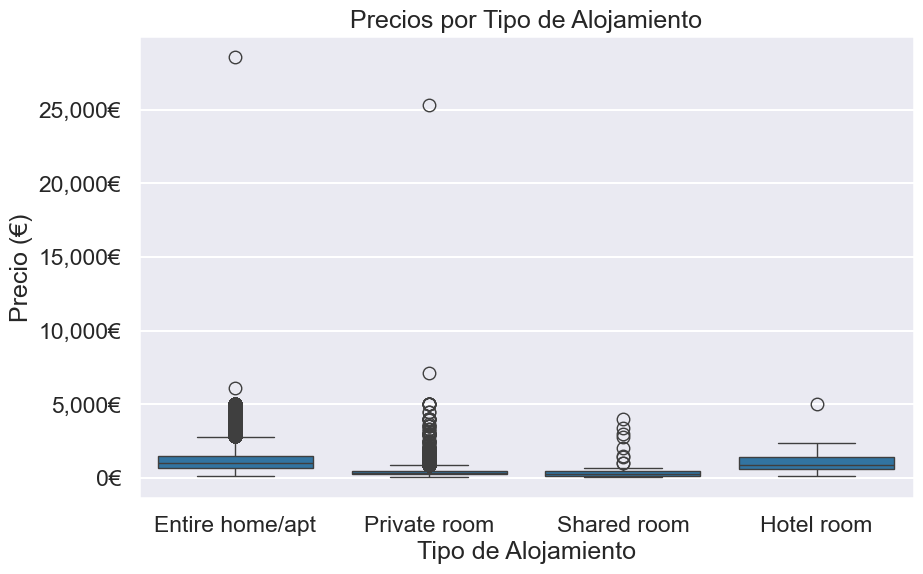

In [56]:
# Boxplot de precios por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='price', data=df)
plt.title('Precios por Tipo de Alojamiento')
plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numeros de cama

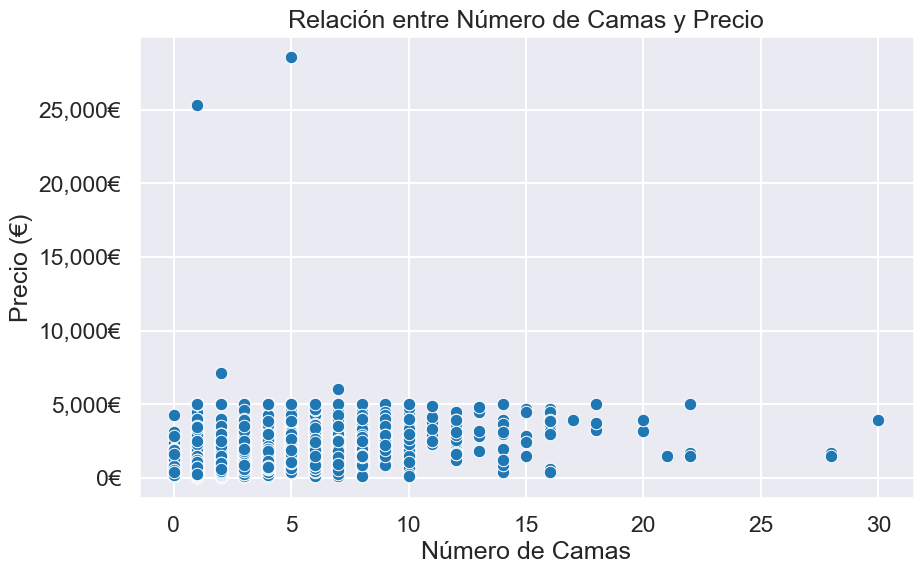

In [57]:
# Relación entre el número de camas y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='beds', y='price', data=df)
plt.title('Relación entre Número de Camas y Precio')
plt.xlabel('Número de Camas')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

##### Precios por numero de habitaciones

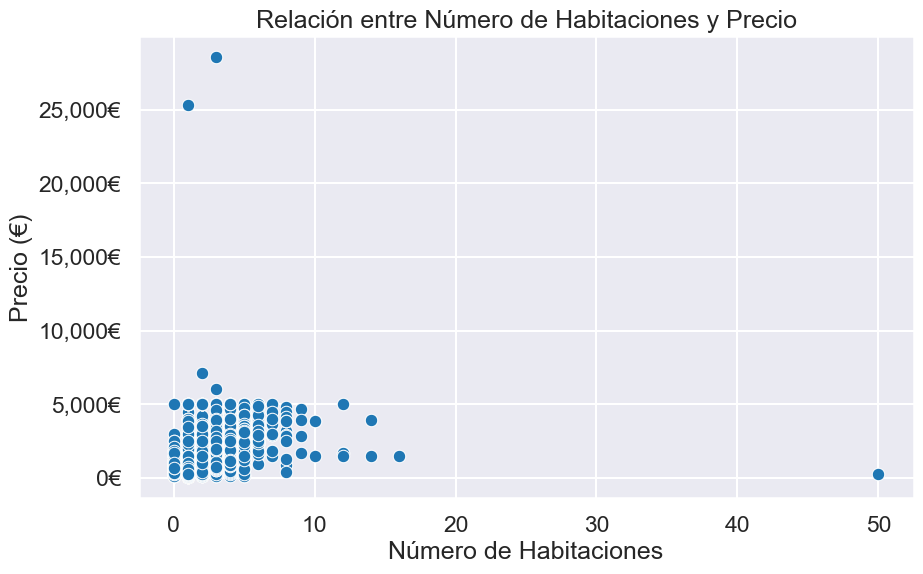

In [58]:
# Relación entre el número de habitaciones y el precio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bedrooms', y='price', data=df)
plt.title('Relación entre Número de Habitaciones y Precio')
plt.xlabel('Número de Habitaciones')
plt.ylabel('Precio (€)')
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(euro_formatter))
plt.show()

#### Reserva instantanea y Distribucion

##### Porcentaje de alojamiento con reserva instantanea

In [59]:
instant_bookable_percentage = df['is_instant_bookable'].value_counts(normalize=True) * 100
print(instant_bookable_percentage)

is_instant_bookable
VERDADERO    57.958549
FALSO        42.041451
Name: proportion, dtype: float64


##### Distribución de alojamientos con reserva instantánea

/var/folders/zd/c44thsy53rq3c4k8x7lqbfdh0000gn/T/ipykernel_3360/1596701451.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




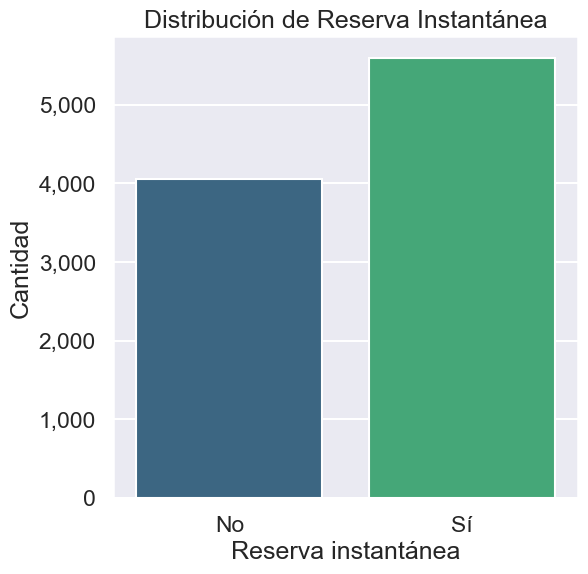

In [60]:
plt.figure(figsize=(6, 6))
sns.countplot(x='is_instant_bookable', data=df, palette='viridis')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Reserva instantánea')
plt.ylabel('Cantidad')
plt.title('Distribución de Reserva Instantánea')
plt.xticks([0, 1], ['No', 'Sí'])
plt.show()

#### Analisis de reseñas

##### Numero de reseñas y puntuaciones

Reseñas

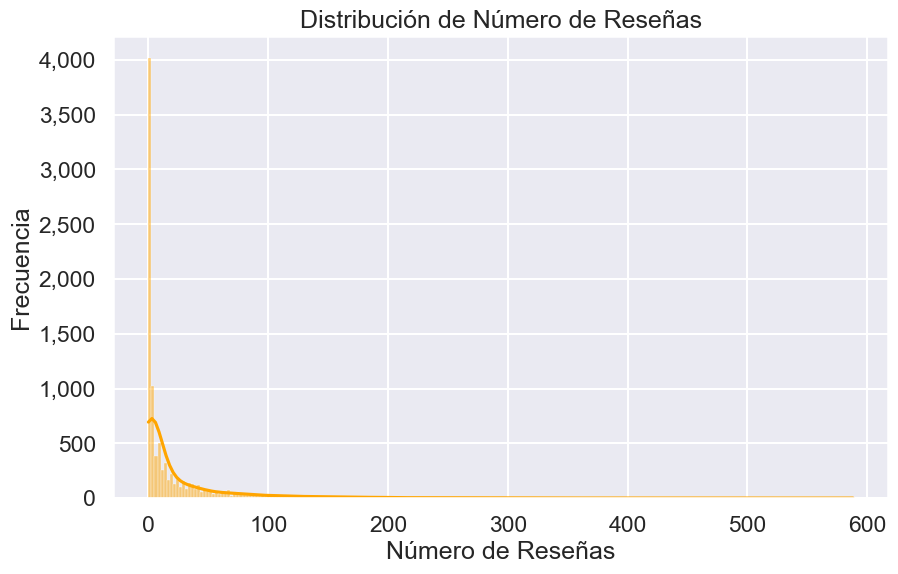

In [61]:
# Histograma de número de reseñas
plt.figure(figsize=(10, 6))
sns.histplot(df['number_of_reviews'], kde=True, color='orange')

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.title('Distribución de Número de Reseñas')
plt.xlabel('Número de Reseñas')
plt.ylabel('Frecuencia')
plt.show()

Puntuaciones

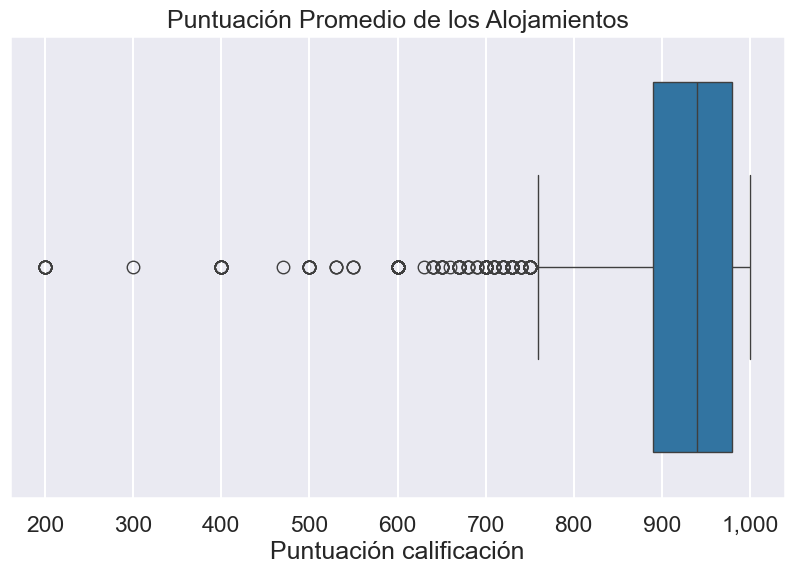

In [62]:
 # Boxplot de puntuaciones
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_scores_rating', data=df)

plt.gca().xaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Puntuación calificación')
plt.title('Puntuación Promedio de los Alojamientos')
plt.show()

##### Puntuaciones por tipo de alojamiento

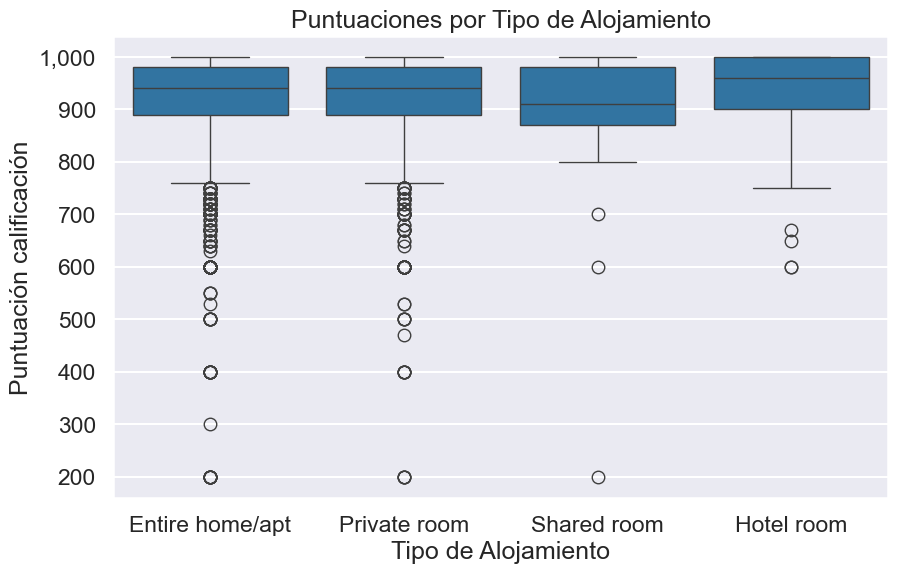

In [63]:
# Boxplot de puntuaciones por tipo de alojamiento
plt.figure(figsize=(10, 6))
sns.boxplot(x='room_type', y='review_scores_rating', data=df)

plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles))

plt.xlabel('Tipo de Alojamiento')
plt.ylabel('Puntuación calificación')
plt.title('Puntuaciones por Tipo de Alojamiento')
plt.show()

# KPIs

## KPI 1 - Tasa de ocupación mensual

### Tasa de ocupacion mensual general

In [64]:
# Suponiendo que 'availability_30' es el número de días disponibles en los últimos 30 días

# Calcular el número de días ocupados
df['days_occupied'] = 30 - df['availability_30']  # Si 'availability_30' tiene los días disponibles, restamos a 30

# Calcular la tasa de ocupación mensual
df['occupancy_rate'] = (df['days_occupied'] / 30) * 100  # Tasa de ocupación en porcentaje

# Mostrar las primeras filas con el KPI calculado
df[['apartment_id', 'city', 'room_type', 'availability_30', 'days_occupied', 'occupancy_rate']]

,apartment_id,city,room_type,availability_30,days_occupied,occupancy_rate
3092,15248525,girona,Entire home/apt,30,0,0.000000
9896,44391173,girona,Private room,30,0,0.000000
7927,32088176,girona,Entire home/apt,0,30,100.000000
9966,45803831,menorca,Entire home/apt,1,29,96.666667
9857,43993521,girona,Entire home/apt,27,3,10.000000
...,...,...,...,...,...,...
2635,13707226,barcelona,Private room,30,0,0.000000
3197,15713525,barcelona,Private room,0,30,100.000000
102,544995,barcelona,Entire home/apt,30,0,0.000000
405,1346199,barcelona,Entire home/apt,30,0,0.000000


In [65]:
# Calcular el total de días ocupados y el total de días analizados
total_days_occupied = df['days_occupied'].sum()
total_days_analyzed = len(df) * 30  # 30 días por cada propiedad

# Calcular la tasa de ocupación general
general_occupancy_rate = (total_days_occupied / total_days_analyzed) * 100

# Mostrar el resultado
print(f"La tasa de ocupación general final es: {general_occupancy_rate:.2f}%")

La tasa de ocupación general final es: 56.67%


In [66]:
fig = go.Figure(go.Indicator(
    mode = "number+gauge+delta",
    gauge = {'shape': "bullet", 
             'axis': {'visible': False}},
    delta = {'reference': 59.24,
             'valueformat': '.2f',
             'suffix' : '%'}, 
    value = general_occupancy_rate,
    domain = {'x': [0.2, 1], 'y': [0.2, 0.9]},
    title = {'text': "Puntuación media general",
             'align': 'right'},
    number = {'valueformat': '.2f',
             'suffix' : '%'}
    ))

fig.show()

In [67]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

        city occupancy_rate
0  barcelona         60.11%
1     girona         50.44%
2     madrid         60.90%
3     malaga         57.29%
4   mallorca         53.54%
5    menorca         52.45%
6    sevilla         50.74%
7   valencia         55.50%


### KPI 1 - Tasa de ocupación por tipo de alojamiento:
    KPI de ocupación promedio por ciudad y tipo de alojamiento.

In [68]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         61.91%
1   barcelona       Hotel room         61.75%
2   barcelona     Private room         59.04%
3   barcelona      Shared room         35.56%
4      girona  Entire home/apt         51.00%
5      girona       Hotel room         50.91%
6      girona     Private room         41.57%
7      girona      Shared room          0.00%
8      madrid  Entire home/apt         61.13%
9      madrid       Hotel room         51.19%
10     madrid     Private room         61.40%
11     madrid      Shared room         42.11%
12     malaga  Entire home/apt         57.09%
13     malaga       Hotel room         30.00%
14     malaga     Private room         58.75%
15     malaga      Shared room         76.67%
16   mallorca  Entire home/apt         53.85%
17   mallorca       Hotel room         72.75%
18   mallorca     Private room         48.39%
19   mallorca      Shared room         57.50%
20    menorca  Entire home/apt    

### KPI 1 - Tasa de ocupación agrupada por ciudad y tipo de alojamiento en %

In [69]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Mostrar el KPI por ciudad y tipo de alojamiento
print(kpi_occupancy)

         city        room_type occupancy_rate
0   barcelona  Entire home/apt         61.91%
1   barcelona       Hotel room         61.75%
2   barcelona     Private room         59.04%
3   barcelona      Shared room         35.56%
4      girona  Entire home/apt         51.00%
5      girona       Hotel room         50.91%
6      girona     Private room         41.57%
7      girona      Shared room          0.00%
8      madrid  Entire home/apt         61.13%
9      madrid       Hotel room         51.19%
10     madrid     Private room         61.40%
11     madrid      Shared room         42.11%
12     malaga  Entire home/apt         57.09%
13     malaga       Hotel room         30.00%
14     malaga     Private room         58.75%
15     malaga      Shared room         76.67%
16   mallorca  Entire home/apt         53.85%
17   mallorca       Hotel room         72.75%
18   mallorca     Private room         48.39%
19   mallorca      Shared room         57.50%
20    menorca  Entire home/apt    

### KPI 1 - Matriz Tasa de ocupación por ciudad y tipo de alojamientos en %

In [70]:
# Agrupar por ciudad y tipo de alojamiento y calcular la tasa de ocupación promedio
kpi_occupancy = df.groupby(['city', 'room_type'])['occupancy_rate'].mean().reset_index()

# Formatear el 'occupancy_rate' a porcentaje con 2 decimales
kpi_occupancy['occupancy_rate'] = kpi_occupancy['occupancy_rate'].apply(lambda x: f"{x:.2f}%")

# Convertir el dataframe a una matriz con las ciudades como filas y los tipos de alojamiento como columnas
occupancy_matrix = kpi_occupancy.pivot_table(index='city', columns='room_type', values='occupancy_rate', aggfunc='first')

# Para reemplazar por 0 si NaN
occupancy_matrix = occupancy_matrix.fillna('0.00%')

# Convertir a formato tabla con tabulate para una mejor visualización en rejilla
occupancy_matrix_formatted = tabulate(occupancy_matrix, headers='keys', tablefmt='grid', showindex=True)

# Mostrar la tabla en formato rejilla
print(occupancy_matrix_formatted)

+-----------+-------------------+--------------+----------------+---------------+
| city      | Entire home/apt   | Hotel room   | Private room   | Shared room   |
+===========+===================+==============+================+===============+
| barcelona | 61.91%            | 61.75%       | 59.04%         | 35.56%        |
+-----------+-------------------+--------------+----------------+---------------+
| girona    | 51.00%            | 50.91%       | 41.57%         | 0.00%         |
+-----------+-------------------+--------------+----------------+---------------+
| madrid    | 61.13%            | 51.19%       | 61.40%         | 42.11%        |
+-----------+-------------------+--------------+----------------+---------------+
| malaga    | 57.09%            | 30.00%       | 58.75%         | 76.67%        |
+-----------+-------------------+--------------+----------------+---------------+
| mallorca  | 53.85%            | 72.75%       | 48.39%         | 57.50%        |
+-----------+---

## KPI 2 - Ciudad con mayor ocupación mensual

In [71]:
# La tasa de ocupación mensual ya la tenemos calculada

# Agrupar por ciudad y calcular la tasa de ocupación promedio mensual
occupancy_by_city = df.groupby('city')['occupancy_rate'].mean().reset_index()

# Encontrar la ciudad con mayor tasa de ocupación mensual
max_occupancy_city = occupancy_by_city.loc[occupancy_by_city['occupancy_rate'].idxmax()]

# Mostrar la ciudad con mayor ocupación
print(f"La ciudad con mayor ocupación mensual es {max_occupancy_city['city']} con una tasa de ocupación del {max_occupancy_city['occupancy_rate']:.2f}%")



La ciudad con mayor ocupación mensual es madrid con una tasa de ocupación del 60.90%


## KPI 3 - Índice de satisfacción general

In [72]:
Indice_satisfaccion_general = df['review_scores_value'].sum() / df['apartment_id'].count()

print(f'El índice de satisfacción general es: {Indice_satisfaccion_general:.2f}')

El índice de satisfacción general es: 67.24


In [73]:
fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = Indice_satisfaccion_general,
    title = {'text': "Índice de satisfacción general"},
    delta = {'reference': 73.78, 'valueformat': '.2f'},
    gauge= {'axis': {'visible': False}},
    number = {'valueformat': '.2f'}
))

fig.show()

## KPI 4 - Ítem con la mayor puntuación promedio

In [74]:
# Diccionario para traducir los nombres de las columnas de evaluación específicas
traducciones = {
    'review_scores_accuracy': 'Precisión',
    'review_scores_cleanliness': 'Limpieza',
    'review_scores_checkin': 'Entrada',
    'review_scores_communication': 'Comunicación',
    'review_scores_location': 'Ubicación'
}

# Columnas originales
cols = list(traducciones.keys())

# Calcular la media de cada una (ignorando NaN)
mean_scores = df[cols].mean().rename(traducciones)

# Mostrar la métrica con mayor media
max_metric = mean_scores.idxmax()
max_value = mean_scores.max()

print(f"La métrica con la mayor puntuación promedio es: {max_metric} con un valor de {max_value:.2f}")

La métrica con la mayor puntuación promedio es: Entrada con un valor de 96.20


Gráfica de radar para representar las puntuaciones

In [75]:
#Trazamos la gráfica de radar

fig = px.line_polar(df, r=mean_scores.values, theta=mean_scores.index, range_r=(90, 100), line_close=True)
fig.update_traces(fill='toself')

#Añadimos los valores

fig.add_trace(go.Scatterpolar(
    r=mean_scores.values,
    theta=mean_scores.index,
    mode='markers+text',
    marker=dict(color='blue', size=5, symbol='circle'),
    text=mean_scores.values.round(2),
    textposition='top center',
    name='Valores',
    showlegend=False
))

#Marcamos el valor máximo

fig.add_trace(go.Scatterpolar(
    r=[max_value],
    theta=[max_metric],
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Valor máximo',
    showlegend=False
))

# Preguntas de negocio Sprint 1

## Operaciones

### Quina és la disponibilitat mitjana dels allotjaments turístics en els diferents terminis (30, 60, 90 i 365 dies) a cada ciutat?

#### Funciones

In [76]:
def grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje):
    plt.figure(figsize=(12, 8)) 
    
    matrix_combined = disponibilidad_media_porcentaje.copy()

    annotaciones = disponibilidad_media.T.apply(lambda x: x.map(lambda v: f"{round(v)} días"))
    
    sns.heatmap(matrix_combined.T, annot=annotaciones.values, fmt="", cmap='coolwarm', cbar_kws={'label': 'Disponibilidad Media (%)'}, linewidths=1)
    
    plt.title('Matriz de Disponibilidad Media por Ciudad (Porcentaje en colores, Media Normal en celdas)', fontsize=16)
    plt.xlabel('Ciudad', fontsize=12)
    plt.ylabel('Periodo de Disponibilidad', fontsize=12)
    plt.xticks(rotation=45, ha='right')  
    
    plt.tight_layout()
    plt.show()


In [77]:
def distribucion_disponibilidad_kde(df, colores):
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    periodos = ['30', '60', '90', '365']
    disponibilidades = [df['availability_30'], df['availability_60'], df['availability_90'], df['availability_365']]

    for i, (periodo, disponibilidad) in enumerate(zip(periodos, disponibilidades)):
        fila = i // 2
        columna = i % 2
        sns.kdeplot(disponibilidad, fill=True, color=colores[i], ax=ax[fila, columna]) 

        ax[fila, columna].set_title(f'Distribución de la Disponibilidad en los Últimos {periodo} Días', fontsize=12)
        ax[fila, columna].set_xlabel(f'Días Disponibles (Últimos {periodo} días)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    


#### Matriz de distribucion de disponibilidad

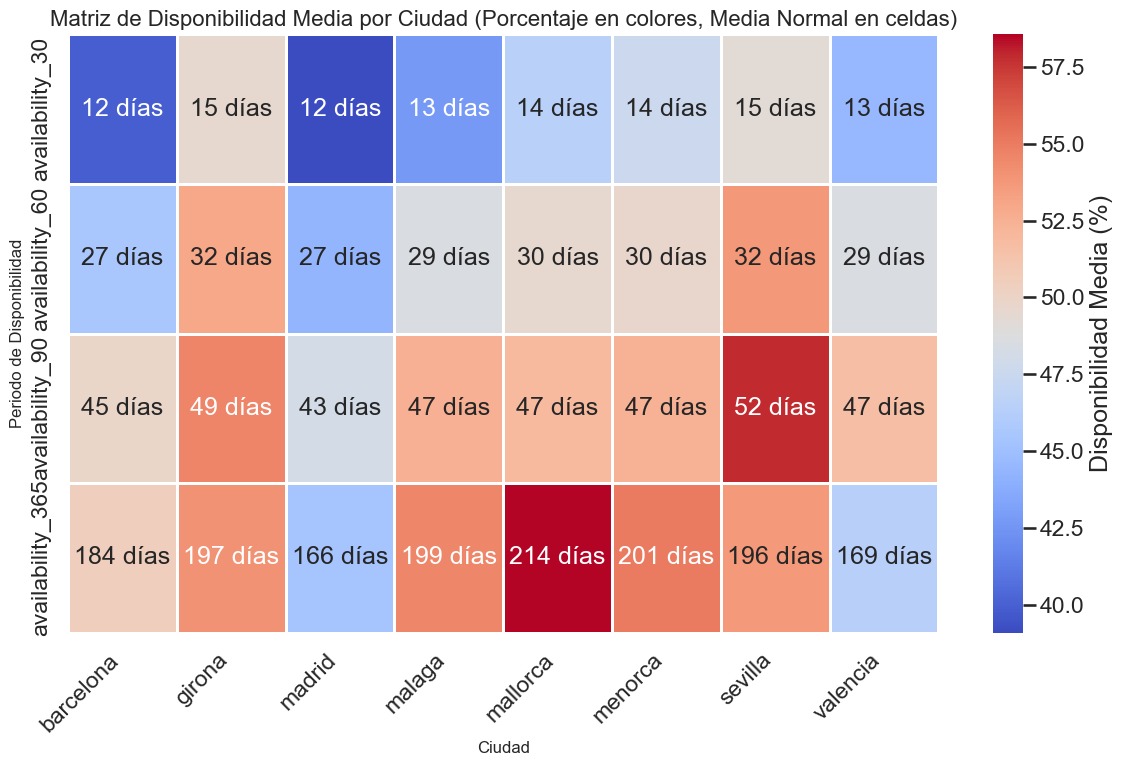

In [78]:
grafico_matriz_disponibilidad(disponibilidad_media, disponibilidad_media_porcentaje)

#### Densidad de distribucion

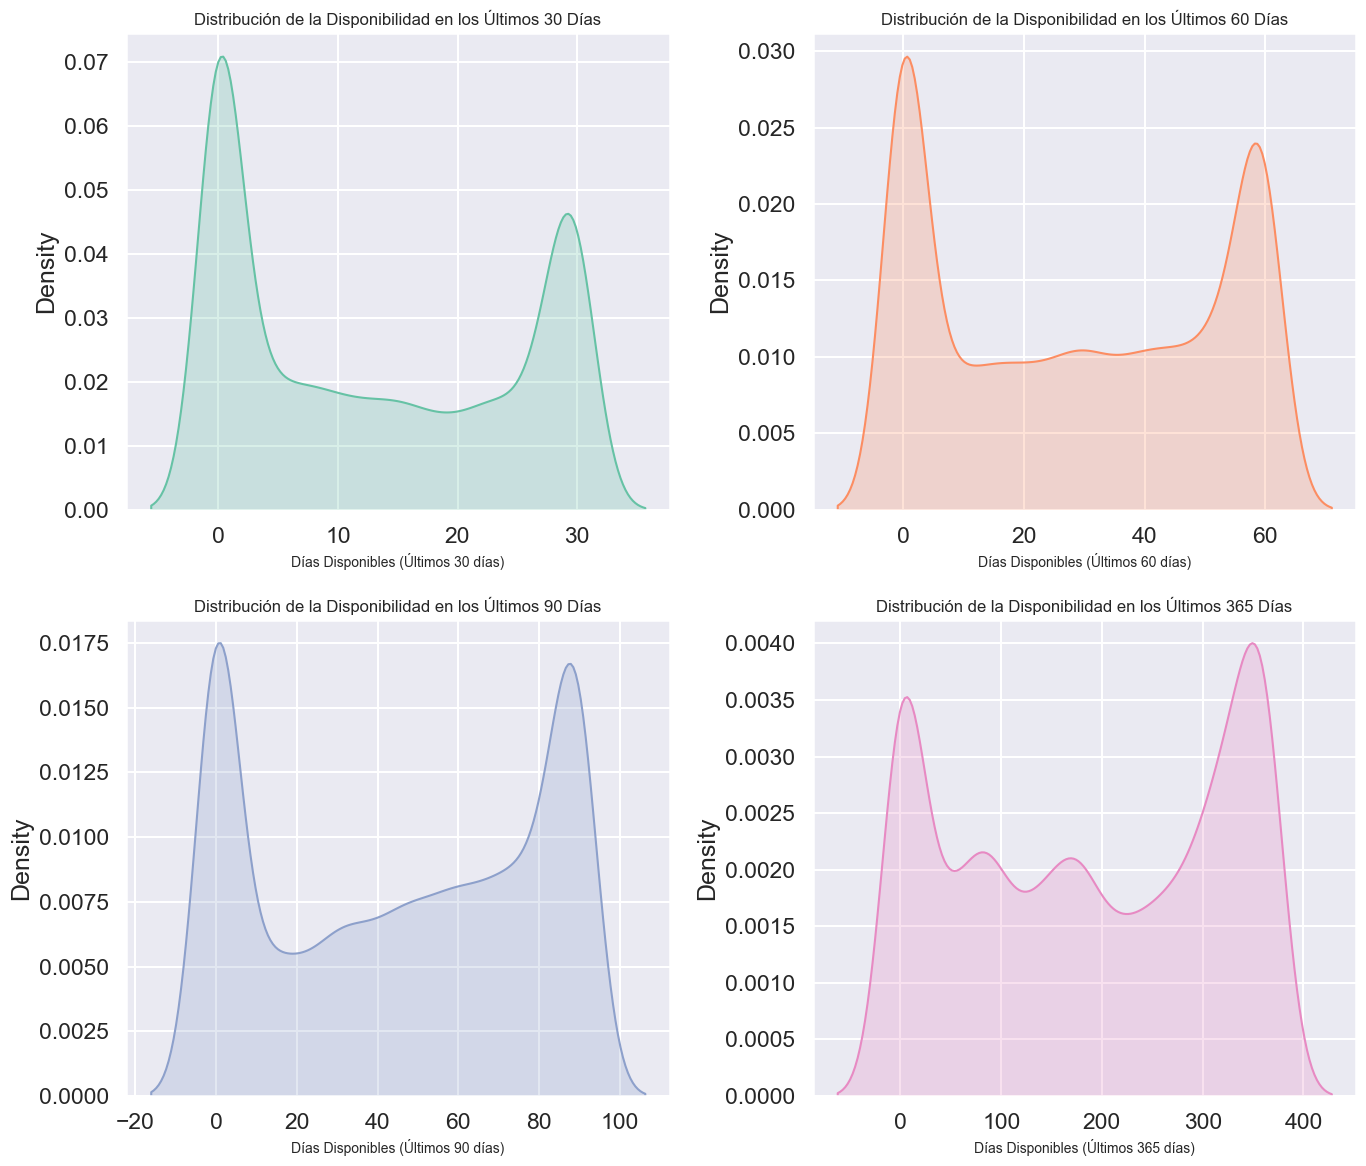

In [79]:
distribucion_disponibilidad_kde(df, colores)

In [80]:
availability_cols = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

# Creamos una pivot table con 'city' como índice, aplicando la función mean para cada columna
availability_matrix = df.pivot_table(
    index='city',
    values=availability_cols,
    aggfunc='mean'
)

print(availability_matrix)

           availability_30  availability_365  availability_60  availability_90
city                                                                          
barcelona        11.967635        184.135344        27.320338        44.840750
girona           14.867340        197.121886        31.797306        49.193266
madrid           11.731022        165.720712        26.604967        43.283037
malaga           12.811508        199.182540        29.117063        47.291667
mallorca         13.936829        213.708781        29.715098        46.694883
menorca          14.266055        200.894495        29.830275        47.165138
sevilla          14.779352        195.775304        32.255061        52.030364
valencia         13.350877        169.274854        29.134503        46.522417


## Marketing

### Quin és el preu mitjà dels allotjaments per tipus d'allotjament a cada ciutat?

In [81]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Renombrar las columnas para mayor claridad
precio_medio.columns = ['Ciudad', 'Tipo de alojamiento', 'Precio medio']

# Formatear el precio medio con 2 decimales y separador de miles
precio_medio['Precio medio'] = precio_medio['Precio medio'].apply(lambda x: f"{x:,.2f}€")

# Mostrar todas los resultados
print(precio_medio)

       Ciudad Tipo de alojamiento Precio medio
0   barcelona     Entire home/apt    1,261.33€
1   barcelona          Hotel room    1,150.00€
2   barcelona        Private room      471.27€
3   barcelona         Shared room      441.83€
4      girona     Entire home/apt    1,258.80€
5      girona          Hotel room      672.73€
6      girona        Private room      683.25€
7      girona         Shared room      150.00€
8      madrid     Entire home/apt      967.29€
9      madrid          Hotel room      842.86€
10     madrid        Private room      479.17€
11     madrid         Shared room      706.67€
12     malaga     Entire home/apt      836.88€
13     malaga          Hotel room      622.50€
14     malaga        Private room      369.78€
15     malaga         Shared room      143.33€
16   mallorca     Entire home/apt    1,788.01€
17   mallorca          Hotel room    1,620.59€
18   mallorca        Private room      882.76€
19   mallorca         Shared room      437.50€
20    menorca

In [82]:
# Agrupar por ciudad y tipo de alojamiento, luego calcular el precio medio
precio_medio = df.groupby(['city', 'room_type'])['price'].mean().reset_index()

# Crear la tabla pivote
tabla_pivote = precio_medio.pivot_table(index='city', columns='room_type', values='price', aggfunc='mean')

# Formatear el precio medio con 2 decimales, separador de miles y símbolo de euro
tabla_pivote = tabla_pivote.applymap(lambda x: f"{x:,.2f}€" if pd.notnull(x) else x)

# Para reemplazar por 0 si NaN
tabla_pivote = tabla_pivote.fillna('0.00€')

# Mostrar la tabla pivote resultante
print(tabla_pivote)

room_type Entire home/apt Hotel room Private room Shared room
city                                                         
barcelona       1,261.33€  1,150.00€      471.27€     441.83€
girona          1,258.80€    672.73€      683.25€     150.00€
madrid            967.29€    842.86€      479.17€     706.67€
malaga            836.88€    622.50€      369.78€     143.33€
mallorca        1,788.01€  1,620.59€      882.76€     437.50€
menorca         1,724.85€      0.00€    1,154.25€       0.00€
sevilla         1,054.34€    819.09€      563.14€     120.00€
valencia          811.23€    770.00€      328.70€     203.33€


/var/folders/zd/c44thsy53rq3c4k8x7lqbfdh0000gn/T/ipykernel_3360/3302454918.py:8: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



## Experiencia de clientes

### Quina és la puntuació mitjana donada pels usuaris als allotjaments turístics, i quin percentatge d'allotjaments tenen una avaluació general més gran de 80 a cada ciutat?


#### Puntuación media de los usuarios

In [83]:
media_valor = df['review_scores_value'].mean()
print(f"Puntuación media otorgada por los usuarios: {media_valor:.2f}")

Puntuación media otorgada por los usuarios: 91.35


#### Porcentaje de alojamientos por ciudad que superan una puntuación de 80

In [84]:
# Crear una columna booleana para marcar los que superan 80
df['supera_80'] = df['review_scores_value'] > 80

# Agrupar por ciudad y calcular el porcentaje
porcentaje_por_ciudad = (
    df.groupby('city')['supera_80']
    .mean().sort_values(ascending=False) * 100
).round(2)

# Convertir la Series en un DataFrame con columnas nombradas
porcentaje_por_ciudad = porcentaje_por_ciudad.reset_index()
porcentaje_por_ciudad.columns = ['city', 'supera_80']  # Renombrar columnas para claridad


print(pd.DataFrame(porcentaje_por_ciudad))

        city  supera_80
0    sevilla      79.35
1   valencia      73.10
2     malaga      70.44
3     madrid      67.01
4  barcelona      62.04
5    menorca      52.29
6   mallorca      51.42
7     girona      48.01


#### Graficos

/var/folders/zd/c44thsy53rq3c4k8x7lqbfdh0000gn/T/ipykernel_3360/1776001290.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




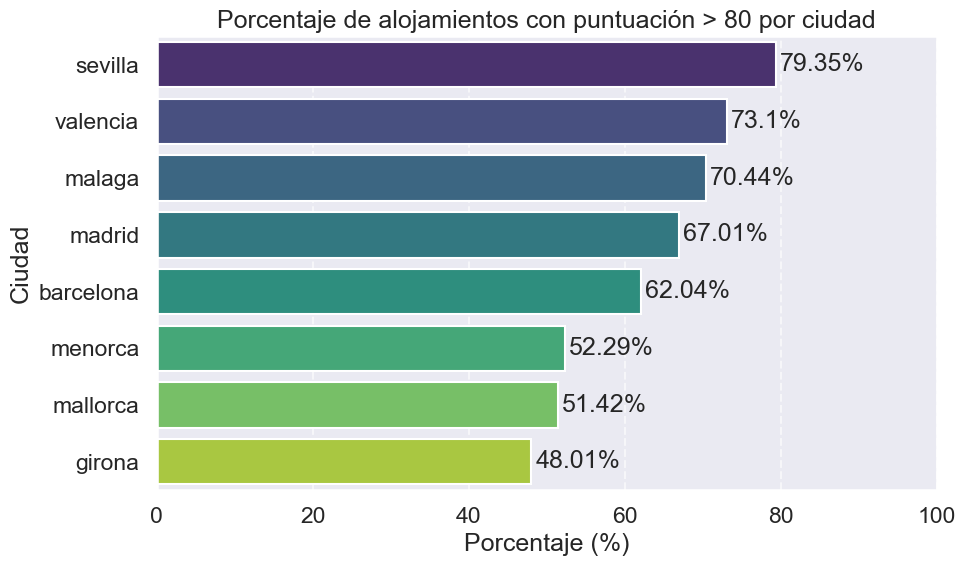

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(data=porcentaje_por_ciudad, x='supera_80', y='city', palette='viridis')

# Anotar porcentajes
for idx, row in enumerate(porcentaje_por_ciudad.itertuples()):
    plt.text(row.supera_80 + 0.5, idx, f"{row.supera_80}%", va='center')

# Ajustes visuales
plt.title('Porcentaje de alojamientos con puntuación > 80 por ciudad')
plt.xlabel('Porcentaje (%)')
plt.ylabel('Ciudad')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Preguntas de negocio Sprint 2

## Operaciones

### Quin impacte té l'opció de reservar automàticament (sense revisió del propietari) a la disponibilitat mitjana a cada ciutat?

In [86]:
df_Book = df.groupby(['city', 'is_instant_bookable'])[['availability_30', 'availability_60', 'availability_90', 'availability_365']].mean().reset_index()
pivot_df_Book = df_Book.pivot(index='city', columns='is_instant_bookable', values=['availability_30', 'availability_60', 'availability_90', 'availability_365'])

In [87]:
pivot_df_Book.columns = ['{}_{}'.format(col[0], col[1]) for col in pivot_df_Book.columns]

# 2. Renombrar las columnas a nombres más descriptivos
pivot_df_Book = pivot_df_Book.rename(columns={
    'availability_30_VERDADERO': 'Disponibilidad 30 días (con reserva instantánea)',
    'availability_30_FALSO': 'Disponibilidad 30 días (sin reserva instantánea)',
    'availability_60_VERDADERO': 'Disponibilidad 60 días (con reserva instantánea)',
    'availability_60_FALSO': 'Disponibilidad 60 días (sin reserva instantánea)',
    'availability_90_VERDADERO': 'Disponibilidad 90 días (con reserva instantánea)',
    'availability_90_FALSO': 'Disponibilidad 90 días (sin reserva instantánea)',
    'availability_365_VERDADERO': 'Disponibilidad 365 días (con reserva instantánea)',
    'availability_365_FALSO': 'Disponibilidad 365 días (sin reserva instantánea)'
})


pivot_df_Book.round(2)

,Disponibilidad 30 días (sin reserva instantánea),Disponibilidad 30 días (con reserva instantánea),Disponibilidad 60 días (sin reserva instantánea),Disponibilidad 60 días (con reserva instantánea),Disponibilidad 90 días (sin reserva instantánea),Disponibilidad 90 días (con reserva instantánea),Disponibilidad 365 días (sin reserva instantánea),Disponibilidad 365 días (con reserva instantánea)
city,,,,,,,,
barcelona,12.06,11.87,27.11,27.54,44.08,45.63,177.60,190.91
girona,16.70,13.75,35.52,29.52,55.27,45.48,230.98,176.45
madrid,11.70,11.75,25.63,27.31,41.14,44.84,158.88,170.68
malaga,12.93,12.77,29.20,29.09,47.65,47.15,198.52,199.44
mallorca,13.78,14.03,29.91,29.60,47.56,46.18,218.42,210.90
menorca,15.05,13.64,30.85,29.02,48.64,45.98,214.01,190.38
sevilla,13.74,15.23,30.19,33.14,49.22,53.24,192.19,197.32
valencia,13.91,12.88,30.39,28.08,47.98,45.29,176.43,163.23


In [88]:
# Coeficiente de disponibilidad
pivot_df_Book['Coeficiente (30 días)'] = (
    pivot_df_Book['Disponibilidad 30 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 30 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 30 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 30 días (sin reserva instantánea)']
)

pivot_df_Book['Coeficiente (60 días)'] = (
    pivot_df_Book['Disponibilidad 60 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 60 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 60 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 60 días (sin reserva instantánea)']
)

pivot_df_Book['Coeficiente (90 días)'] = (
    pivot_df_Book['Disponibilidad 90 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 90 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 90 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 90 días (sin reserva instantánea)']
)

pivot_df_Book['Coeficiente (365 días)'] = (
    pivot_df_Book['Disponibilidad 365 días (sin reserva instantánea)'] - 
    pivot_df_Book['Disponibilidad 365 días (con reserva instantánea)']
) / (
    pivot_df_Book['Disponibilidad 365 días (con reserva instantánea)'] + 
    pivot_df_Book['Disponibilidad 365 días (sin reserva instantánea)']
)

In [89]:
pivot_df_Book[["Coeficiente (30 días)","Coeficiente (60 días)","Coeficiente (90 días)","Coeficiente (365 días)"]].round(2)

,Coeficiente (30 días),Coeficiente (60 días),Coeficiente (90 días),Coeficiente (365 días)
city,,,,
barcelona,0.01,-0.01,-0.02,-0.04
girona,0.10,0.09,0.10,0.13
madrid,-0.00,-0.03,-0.04,-0.04
malaga,0.01,0.00,0.01,-0.00
mallorca,-0.01,0.01,0.01,0.02
menorca,0.05,0.03,0.03,0.06
sevilla,-0.05,-0.05,-0.04,-0.01
valencia,0.04,0.04,0.03,0.04


In [90]:
# Generar las posiciones para cada ciudad
ind = np.arange(len(pivot_df_Book))  

# Extraer los coeficientes para cada período
coef30 = pivot_df_Book['Coeficiente (30 días)']
coef60 = pivot_df_Book['Coeficiente (60 días)']
coef90 = pivot_df_Book['Coeficiente (90 días)']
coef365 = pivot_df_Book['Coeficiente (365 días)']

fig = go.Figure()

# Añadir cada grupo de barras con colores específicos
fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef30,
    name='30 días',
    marker_color='#ADD8E6'  # Azul claro
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef60,
    name='60 días',
    marker_color='#87CEEB'  # Azul cielo
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef90,
    name='90 días',
    marker_color='#4682B4'  # Azul acero
))

fig.add_trace(go.Bar(
    x=pivot_df_Book.index,
    y=coef365,
    name='365 días',
    marker_color='#00008B'  # Azul oscuro
))

fig.update_layout(
    title='Coeficiente por Ciudad y Período',
    xaxis_title='Ciudad',
    yaxis_title='Coeficiente',
    barmode='group',  # Agrupar las barras
    yaxis=dict(range=[-0.2, 0.2]),  # Ajustar el rango del eje Y
    plot_bgcolor='rgba(0,0,0,0)',  # Fondo transparente
    legend=dict(title='Período', font=dict(size=12))
)

# Añadir una línea horizontal en y=0
fig.add_shape(type='line',
              x0=0, x1=1, y0=0, y1=0,
              xref='paper', yref='y',
              line=dict(color='black', width=1))

fig.show()

In [91]:
# Agrupar los datos por ciudad y calcular cuántos pisos tienen reservas automáticas y cuántos no
tabla_resumen_Book = df.groupby(['city', 'is_instant_bookable']).size().unstack(fill_value=0)

# Renombrar las columnas 
tabla_resumen_Book.columns = ['Sin Reserva Automática', 'Con Reserva Automática']

# Recalcular las columnas de porcentaje
tabla_resumen_Book['% Con Reserva Automática'] = (tabla_resumen_Book['Con Reserva Automática'] / tabla_resumen_Book[['Sin Reserva Automática', 'Con Reserva Automática']].sum(axis=1)) * 100
tabla_resumen_Book['% Sin Reserva Automática'] = (tabla_resumen_Book['Sin Reserva Automática'] / tabla_resumen_Book[['Sin Reserva Automática', 'Con Reserva Automática']].sum(axis=1)) * 100

# Aplicar estilo con formato para porcentajes redondeados y con símbolo %
tabla_resumen_Book_styled = tabla_resumen_Book[['% Con Reserva Automática', '% Sin Reserva Automática']].style.format({
    '% Con Reserva Automática': '{:.2f}%',  # 2 decimales con símbolo %
    '% Sin Reserva Automática': '{:.2f}%'   # 2 decimales con símbolo %
}).background_gradient(cmap='Blues')  # Añadir gradiente de color

tabla_resumen_Book_styled


,% Con Reserva Automática,% Sin Reserva Automática
city,,
barcelona,49.10%,50.90%
girona,62.09%,37.91%
madrid,57.97%,42.03%
malaga,72.02%,27.98%
mallorca,62.67%,37.33%
menorca,55.50%,44.50%
sevilla,69.84%,30.16%
valencia,54.19%,45.81%


In [92]:
tabla_resumen_Book

,Sin Reserva Automática,Con Reserva Automática,% Con Reserva Automática,% Sin Reserva Automática
city,,,,
barcelona,1384,1335,49.098933,50.901067
girona,563,922,62.087542,37.912458
madrid,897,1237,57.966261,42.033739
malaga,141,363,72.023810,27.976190
mallorca,591,992,62.665824,37.334176
menorca,97,121,55.504587,44.495413
sevilla,149,345,69.838057,30.161943
valencia,235,278,54.191033,45.808967


In [93]:
valores_unicos = df["is_instant_bookable"].unique()
valores_unicos

array(['FALSO', 'VERDADERO'], dtype=object)

In [94]:
# Calcular la tasa de ocupación promedio mensual por ciudad y por opción de reserva instantánea
occupancy_by_city_instant_booking = df.groupby(['city', 'is_instant_bookable'])['occupancy_rate'].mean().reset_index()

instant_booking = occupancy_by_city_instant_booking[occupancy_by_city_instant_booking['is_instant_bookable'] == 'True']
non_instant_booking = occupancy_by_city_instant_booking[occupancy_by_city_instant_booking['is_instant_bookable'] == 'False']

# Comparar la tasa de ocupación promedio entre las dos categorías
print("Tasa de ocupación promedio por ciudad con y sin reserva instantánea:")
occupancy_by_city_instant_booking

Tasa de ocupación promedio por ciudad con y sin reserva instantánea:


,city,is_instant_bookable,occupancy_rate
0,barcelona,FALSO,59.790462
1,barcelona,VERDADERO,60.436954
2,girona,FALSO,44.333925
3,girona,VERDADERO,54.172090
4,madrid,FALSO,60.999628
5,madrid,VERDADERO,60.821881
6,malaga,FALSO,56.903073
7,malaga,VERDADERO,57.447199
8,mallorca,FALSO,54.072194
9,mallorca,VERDADERO,53.229167


In [95]:
occupancy_matrix = occupancy_by_city_instant_booking.pivot(index='city', columns='is_instant_bookable', values='occupancy_rate')

occupancy_matrix.rename(columns={'True': 'Instant Booking', 'False': 'No Instant Booking'}, inplace=True)

occupancy_matrix = occupancy_matrix.round(2)

# Función para formatear los valores con '%'
def add_percentage_format(df):
    return df.map(lambda x: f"{x:.2f}%" if x != 0 else "0%")

occupancy_matrix = add_percentage_format(occupancy_matrix)

# Función para resaltar el mayor y menor valor por fila
def highlight_min_max(s):
    styles = []
    for v in s:
        # Quitar el '%' para comparar los valores numéricos
        value = float(v.strip('%'))
        if value == max(float(v.strip('%')) for v in s):
            styles.append('background-color: darkblue; color: white;')
        elif value == min(float(v.strip('%')) for v in s):
            styles.append('background-color: lightblue; color: black;')
        else:
            styles.append('')
    return styles

styled_matrix = occupancy_matrix.style.apply(highlight_min_max, axis=1)

styled_matrix


is_instant_bookable,FALSO,VERDADERO
city,,
barcelona,59.79%,60.44%
girona,44.33%,54.17%
madrid,61.00%,60.82%
malaga,56.90%,57.45%
mallorca,54.07%,53.23%
menorca,49.83%,54.55%
sevilla,54.21%,49.24%
valencia,53.65%,57.06%


## Marketing

### Quines característiques dels allotjaments (comoditats, capacitat i puntuació de la zona) estan més relacionades amb els preus a cada ciutat?


### 1. Análisis de correlación general por ciudad
    Esto dará, para cada ciudad, qué variables tienen mayor correlación con el precio.

In [96]:
# Seleccionem les columnes rellevants
columnes_interessants = ['city', 'price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'review_scores_location']
df_corr = df[columnes_interessants].dropna()

# Calcular la correlació per ciutat
for ciutat in df_corr['city'].unique():
    print(f"\n📍 Ciutat: {ciutat.upper()}")
    sub_df = df_corr[df_corr['city'] == ciutat]
    correlacions = sub_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)
    print(correlacions)


📍 Ciutat: GIRONA
bedrooms                  0.635288
accommodates              0.629111
bathrooms                 0.595703
beds                      0.587240
review_scores_location    0.039615
Name: price, dtype: float64

📍 Ciutat: MALAGA
bedrooms                  0.527356
accommodates              0.520968
beds                      0.476530
bathrooms                 0.429518
review_scores_location    0.106232
Name: price, dtype: float64

📍 Ciutat: SEVILLA
accommodates              0.321089
beds                      0.273525
bedrooms                  0.258185
bathrooms                 0.234104
review_scores_location    0.085578
Name: price, dtype: float64

📍 Ciutat: MENORCA
bathrooms                 0.631236
accommodates              0.603589
bedrooms                  0.509297
beds                      0.391627
review_scores_location    0.012494
Name: price, dtype: float64

📍 Ciutat: VALENCIA
accommodates              0.457411
beds                      0.451523
bedrooms                

### Idem anterior corrección comentarios Abelardo
    Este código:
    1.- Transforma amenities_list a una variable numérica (amenities_count).

    2.- Filtra columnas relevantes.

    3.- Calcula la correlación entre el price y las demás variables, por ciudad.

    4.- Ordena los resultados para ver cuál variable está más correlacionada con el precio en cada ciudad.

In [97]:
# Crear nueva columna numérica a partir de amenities_list
#df['amenities_count'] = df['amenities_list'].apply(lambda x: len(x.split(',')) if isinstance(x, str) else 0)

# Asegura que todo sea string antes de contar
#df['amenities_count'] = df['amenities_list'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

# Solución robusta y segura: cubre todos los casos posibles: None, float('nan'), strings, listas reales, etc.
def contar_amenities(x):
    if isinstance(x, list):  # Si ya es lista
        return len(x)
    elif isinstance(x, str):  # Si es string
        return len(x.split(','))
    else:
        return 0

df['amenities_count'] = df['amenities_list'].apply(contar_amenities)

# Columnas que queremos correlacionar con el precio
columnes_interessants = ['city', 'price', 'accommodates', 'amenities_count', 'review_scores_location']
df_corr = df[columnes_interessants].dropna()

# Calcular la correlació per ciutat
for ciutat in df_corr['city'].unique():
    print(f"\n📍 Ciutat: {ciutat.upper()}")
    sub_df = df_corr[df_corr['city'] == ciutat]
    correlacions = sub_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)
    print(correlacions)


📍 Ciutat: GIRONA
accommodates              0.630708
amenities_count           0.104850
review_scores_location    0.039748
Name: price, dtype: float64

📍 Ciutat: MALAGA
accommodates              0.521113
review_scores_location    0.104795
amenities_count           0.103442
Name: price, dtype: float64

📍 Ciutat: SEVILLA
accommodates              0.323344
review_scores_location    0.083411
amenities_count          -0.058153
Name: price, dtype: float64

📍 Ciutat: MENORCA
accommodates              0.602485
amenities_count           0.082971
review_scores_location    0.021550
Name: price, dtype: float64

📍 Ciutat: VALENCIA
accommodates              0.458819
review_scores_location    0.058376
amenities_count           0.025703
Name: price, dtype: float64

📍 Ciutat: MALLORCA
accommodates              0.621705
amenities_count           0.115035
review_scores_location   -0.031343
Name: price, dtype: float64

📍 Ciutat: BARCELONA
accommodates              0.648999
amenities_count           0.1980

### Paso 1: Calcular correlación por ciudad (capacidad, camas, puntuación de zona)

In [98]:
# Utilizaremos la nueva columna numérica a partir de amenities_list creada en el punto anterior.

# Variables a analizar incluyendo amenities_count creado en el punto anterior
vars_interes = ['accommodates', 'amenities_count', 'review_scores_location']

# Crear un DataFrame vacío para guardar las correlaciones
correlations_by_city = pd.DataFrame()

# Calcular correlaciones por ciudad
for city in df['city'].dropna().unique():
    sub_df = df[df['city'] == city]
    
    # Verificamos que haya suficientes datos válidos para calcular correlaciones
    if sub_df[vars_interes + ['price']].dropna().shape[0] >= 2:
        corr = sub_df[vars_interes + ['price']].corr(numeric_only=True)['price'].drop('price')
        correlations_by_city[city.upper()] = corr

# Transponer para que las ciudades queden como índice
correlations_by_city = correlations_by_city.T

# Ordenar por nombre de ciudad
correlations_by_city = correlations_by_city.sort_index()

# Mostrar el DataFrame
print(correlations_by_city)


           accommodates  amenities_count  review_scores_location
BARCELONA      0.625303         0.193539               -0.016660
GIRONA         0.607811         0.107576                0.039748
MADRID         0.422783         0.058243                0.102139
MALAGA         0.527364         0.051284                0.104795
MALLORCA       0.415437         0.026000               -0.031343
MENORCA        0.575687         0.069283                0.021550
SEVILLA        0.339966        -0.077912                0.083411
VALENCIA       0.527983         0.039474                0.058376


### Paso 2: Visualizar tabla con fondo de color dinámico

In [99]:
styled_corr = correlations_by_city.style\
    .background_gradient(cmap='YlGnBu')\
    .format("{:.2f}")\
    .set_caption("📊 Correlació entre característiques i preu per ciutat")

styled_corr

,accommodates,amenities_count,review_scores_location
BARCELONA,0.63,0.19,-0.02
GIRONA,0.61,0.11,0.04
MADRID,0.42,0.06,0.10
MALAGA,0.53,0.05,0.10
MALLORCA,0.42,0.03,-0.03
MENORCA,0.58,0.07,0.02
SEVILLA,0.34,-0.08,0.08
VALENCIA,0.53,0.04,0.06


###  2. Análisis de comodidades (“amenities”) relacionadas con el precio
    Podemos analizar si ciertos servicios (como WiFi, aire acondicionado, parking, etc.) están asociados a precios más altos. Suponiendo que normalized_amenities es una lista:

### Código para crear normalized_amenities

In [100]:
# Función de limpieza básica
def limpiar_amenities(x):
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return ''
    elif isinstance(x, list):
        items = x
    elif isinstance(x, str):
        items = [i.strip() for i in x.split(',')]
    else:
        return ''
    
    # Normalizar: quitar espacios, convertir a minúsculas, eliminar duplicados y ordenar
    items = [i.strip().lower() for i in items]
    return ', '.join(sorted(set(items)))

# Crear columna 'normalized_amenities'
df['normalized_amenities'] = df['amenities_list'].apply(limpiar_amenities)

In [101]:
# Creamos una matriz binaria de presencia/ausencia de comodidades
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
amenities_matrix = vectorizer.fit_transform(df['normalized_amenities'].fillna(''))

# Convertir a DataFrame
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Añadir la columna de precio
amenities_df['price'] = df['price'].values

# Correlación entre cada amenity y el precio
correlacions_amenities = amenities_df.corr(numeric_only=True)['price'].drop('price').sort_values(ascending=False)

# Mostrar los 10 amenities con mayor correlación positiva con el precio
print("\n🏷️ Comoditats amb més correlació positiva amb el preu:")
print(correlacions_amenities.head(15))



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'




🏷️ Comoditats amb més correlació positiva amb el preu:
pool                        0.380123
indoor fireplace            0.271977
free parking on premises    0.264360
bbq grill                   0.230161
high chair                  0.220966
crib                        0.209393
dishwasher                  0.200115
garden or backyard          0.196720
tv                          0.182643
bathtub                     0.167900
private entrance            0.153430
family/kid friendly         0.152600
cable tv                    0.152400
air conditioning            0.149954
dryer                       0.143709
Name: price, dtype: float64


### Código para estilizar las correlaciones de amenities con el precio:

In [102]:
# Crear un DataFrame de correlación para las comodidades
styled_amenities = correlacions_amenities.head(15).to_frame().reset_index()
styled_amenities.columns = ['Amenity', 'Correlación con el precio']

# Aplicar estilo
styled_amenities = styled_amenities.style\
    .background_gradient(subset=['Correlación con el precio'], cmap='YlGnBu')\
    .format({'Correlación con el precio': "{:.2f}"})\
    .set_caption("🏷️ Comoditats amb més correlació amb el preu (15 primeres)")

# Mostrar el estilo
styled_amenities

,Amenity,Correlación con el precio
0,pool,0.38
1,indoor fireplace,0.27
2,free parking on premises,0.26
3,bbq grill,0.23
4,high chair,0.22
5,crib,0.21
6,dishwasher,0.20
7,garden or backyard,0.20
8,tv,0.18
9,bathtub,0.17


### Paso 3: Calcular correlación entre comodidades y precio

In [103]:
# Limpiar datos y crear la matriz de comodidades
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(", "))
amenities_matrix = vectorizer.fit_transform(df['normalized_amenities'].fillna(''))

# Convertir a DataFrame
amenities_df = pd.DataFrame(amenities_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Añadir precios
amenities_df['price'] = df['price'].values

# Calcular correlación
correlation_series = amenities_df.corr()['price'].drop('price').sort_values(ascending=False)

# Convertir a DataFrame para visualización
amenities_corr_df = correlation_series.reset_index()
amenities_corr_df.columns = ['Amenidad', 'Correlación con el precio']

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



### Paso 4: Mostrar tabla formateada (comodidades)

In [104]:
styled_amenities = amenities_corr_df.sort_values(by='Correlación con el precio', ascending=False).head(15).style\
    .background_gradient(subset=['Correlación con el precio'], cmap='Oranges')\
    .format({'Correlación con el precio': "{:.2f}"})\
    .set_caption("🛋️ Comoditats amb més correlació amb el preu (15 primeres)")

styled_amenities

,Amenidad,Correlación con el precio
0,pool,0.38
1,indoor fireplace,0.27
2,free parking on premises,0.26
3,bbq grill,0.23
4,high chair,0.22
5,crib,0.21
6,dishwasher,0.20
7,garden or backyard,0.20
8,tv,0.18
9,bathtub,0.17


## Clientes

### Quins aspectes (precisió de detalls, higiene, check-in o comunicació) presenten diferències més grans entre els allotjaments millor i pitjor valorats en l'avaluació general?

El aspecto con la valoración más dispar es: Precisión    80.0
Limpieza     80.0
dtype: float64 con una diferencia de 80.00 puntos


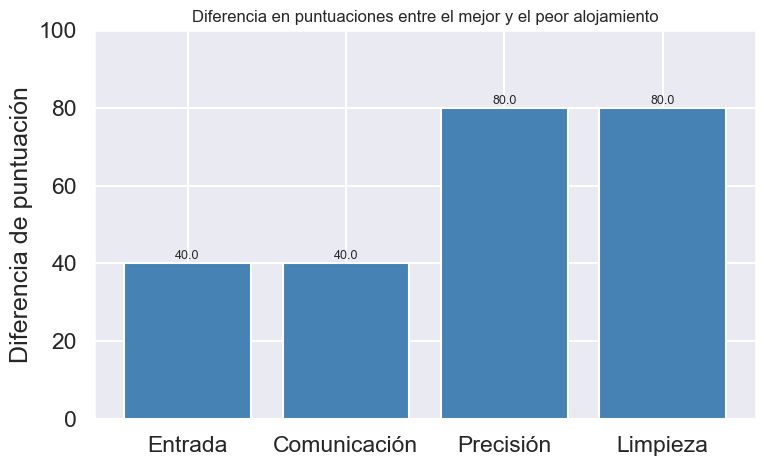

In [105]:
# Seleccionamos las características evaluadas que nos interesan, eliminando localización    
cols.remove('review_scores_location')

# Eliminar filas con valores nulos en estas columnas y en la puntuación global
df_clean = df.dropna(subset=cols + ['review_scores_value'])

# Calculamos el valor más habitual de cada característica por puntuación global
df_mediana = df_clean.groupby('review_scores_value')[cols].median().reset_index()
df_mediana

# Identificamos la valoración más alta y más baja de los alojamientos
mejor = df_mediana.loc[df_mediana['review_scores_value'].idxmax()]
peor = df_mediana.loc[df_mediana['review_scores_value'].idxmin()]

# Calcular diferencias
diferencias = (mejor[cols] - peor[cols]).sort_values().rename(traducciones)

max_diferencia = diferencias.max()
max_items = diferencias[diferencias == max_diferencia]

print(f"El aspecto con la valoración más dispar es: {max_items} con una diferencia de {max_diferencia:.2f} puntos")

# Gráfico
plt.figure(figsize=(8, 5))
bars = plt.bar(diferencias.index, diferencias.values, color='steelblue')
plt.title('Diferencia en puntuaciones entre el mejor y el peor alojamiento', fontsize=12)
plt.ylabel('Diferencia de puntuación')
plt.ylim(0, 100)

# Etiquetas encima de las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.3, f'{yval:.1f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()


In [106]:
# Gráfica de radar plotly
#Trazamos la gráfica de radar

fig = px.line_polar(df, r=diferencias.values, theta=diferencias.index, range_r=(0, 100), line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(title_text='Diferencia global de valoraciones', title_x=0.5)

#Añadimos los valores

fig.add_trace(go.Scatterpolar(
    r=diferencias.values,
    theta=diferencias.index,
    mode='markers+text',
    marker=dict(color='blue', size=5, symbol='circle'),
    text=diferencias.values,
    textposition='top center',
    name='Valores',
    showlegend=False
))

#Marcamos el valor máximo

fig.add_trace(go.Scatterpolar(
    r=max_items.values,
    theta=max_items.index,
    mode='markers',
    marker=dict(color='red', size=10, symbol='circle'),
    name='Valor máximo',
    showlegend=False
))

Segmentamos por ciudad

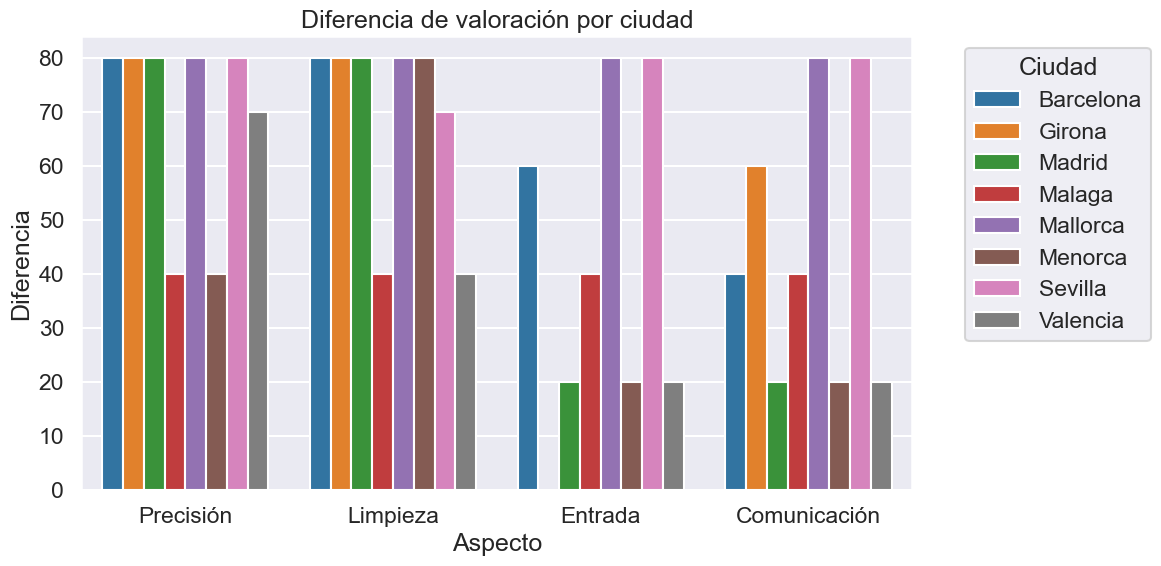

In [107]:
# Filtrar filas con datos completos
df_clean = df.dropna(subset=cols + ['review_scores_value', 'city'])

# Agrupar por ciudad
grouped = df_clean.groupby('city') #Gráfica de barras apilada

#Agrupar por ciudad y calcular diferencias
records = []
for city, group in df_clean.groupby('city'):
    mejor = group.loc[group['review_scores_rating'].idxmax()]
    peor = group.loc[group['review_scores_rating'].idxmin()]
    diferencias = (mejor[cols] - peor[cols]).rename(traducciones)
    for aspecto, valor in diferencias.items():
        records.append({
            'Ciudad': city.capitalize(),
            'Aspecto': aspecto,
            'Diferencia': valor
        })

# Crear DataFrame en formato largo
long_df = pd.DataFrame(records)

# Crear gráfica
plt.figure(figsize=(12, 6))
sns.barplot(data=long_df, x='Aspecto', y='Diferencia', hue='Ciudad')

# Ajustes estéticos
plt.title("Diferencia de valoración por ciudad")
plt.ylabel("Diferencia")
plt.legend(title="Ciudad", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Segmentamos por tipo de alojamiento

In [108]:
# Traducción tipo de alojamiento
trad_alojamientos = {
    'Entire home/apt' : 'Vivienda',
    'Hotel room' : 'Hotel',
    'Private room' : 'Hab. privada',
    'Shared room' : 'Hab. compartida'
}

# Filtrar filas con datos completos
df_clean = df.dropna(subset=cols + ['review_scores_value', 'room_type'])

# Agrupar solo por tipo de alojamiento
grouped = df_clean.groupby('room_type')

# Inicializar figura
fig = go.Figure()

# Añadir una traza por tipo de alojamiento
for room_type, group in grouped:
    mejor = group.loc[group['review_scores_value'].idxmax()]
    peor = group.loc[group['review_scores_value'].idxmin()]
    diferencias = (mejor[cols] - peor[cols]).rename(traducciones)

    # Etiquetas más limpias
    theta_labels = diferencias.index
    r_values = diferencias.values

    fig.add_trace(go.Scatterpolar(
        r=r_values,
        theta=theta_labels,
        fill='toself',
        name=trad_alojamientos.get(room_type, room_type),
        mode='lines+markers',
        opacity=0.6  # Mejora la legibilidad al superponer
    ))

# Configuración del gráfico
fig.update_layout(
    autosize=False,
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, df_clean[cols].max().max()]
        )
    ),
    title="Diferencia de valoración por tipo de alojamiento",
    title_x=0.5,
    showlegend=True
)

fig.show()


# CSV

In [113]:
df.to_csv("../Data/2025_04_28_Sprint03.csv", index=False)

In [112]:
df

,apartment_id,name,description,host_id,neighbourhood_name,neighbourhood_district,room_type,accommodates,bathrooms,bedrooms,...,reviews_per_month,country,city,insert_date,amenities_normalized,days_occupied,occupancy_rate,supera_80,amenities_count,normalized_amenities
3092,15248525,"appt dans villa � Llansa ,beau jardin,terrasse",Mon logement est proche de la plage et des com...,84213236,Llan��,NaN,Entire home/apt,6,1,2,...,66.0,spain,girona,2021-02-27,"air conditioning, balcony, bathroom essentials...",0,0.000000,True,27,"childrenu2019s books and toys, cleaning before..."
9896,44391173,Hostal Escadarcs 1780,"Peque�o hostal construido de 1780, situado en ...",358199210,Fontanals de Cerdanya,NaN,Private room,16,0,2,...,NaN,spain,girona,2021-02-27,"air conditioning, bathroom essentials, bathroo...",0,0.000000,False,10,"essentials, fire extinguisher, hair dryer, han..."
7927,32088176,"Two-level apartment, wifi, terrace, swimming pool","Authentic 2 level apartment, located on the su...",240662122,Lloret de Mar,NaN,Entire home/apt,4,1,1,...,57.0,spain,girona,2021-02-27,"24-hour check-in, balcony, bathroom essentials...",30,100.000000,True,29,"coffee maker, cooking basics, dedicated worksp..."
9966,45803831,Villa Solecito at Illes Balears,Villa Solecito provides a most comfortable and...,345010290,Mah�n,NaN,Entire home/apt,12,6,6,...,NaN,spain,menorca,2021-02-27,"air conditioning, bathroom essentials, bathroo...",29,96.666667,False,22,"air conditioning, bed linens, cable tv, coffee..."
9857,43993521,"Apartment Sant Lluis,2 minutes walk from the b...",Apartments located in the central part of Llor...,59318446,Lloret de Mar,NaN,Entire home/apt,6,1,2,...,29.0,spain,girona,2021-02-27,"air conditioning, bathroom essentials, bathroo...",3,10.000000,True,23,"air conditioning, bed linens, carbon monoxide ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2635,13707226,"Remarkable Value, Unbeatable Location",A spacious double bedroom with a balcony. It's...,80008404,el Barri G�tic,Ciutat Vella,Private room,2,4,1,...,25.0,spain,barcelona,2017-01-04,"air conditioning, bathroom essentials, bathroo...",0,0.000000,True,20,"air conditioning, buzzer/wireless intercom, dr..."
3197,15713525,Nice room in classic eixample flat with balcony,"Lugares de inter�s: Cervecer�a Catalana, Casa ...",3297768,l'Antiga Esquerra de l'Eixample,Eixample,Private room,1,2,1,...,52.0,spain,barcelona,2017-01-04,"bathroom essentials, bathroom extras, dining a...",30,100.000000,True,18,"breakfast, carbon monoxide detector, dryer, el..."
102,544995,LUXURY HOUSE IN BCN NEAR THE BEACH,SPECIAL OFFER! LUXURY HOUSE IN BCN NEAR THE BE...,2556699,la Vila Ol�mpica del Poblenou,Sant Mart�,Entire home/apt,6,3,3,...,39.0,spain,barcelona,2017-01-04,"24-hour check-in, air conditioning, bathroom e...",0,0.000000,True,20,"24-hour check-in, air conditioning, buzzer/wir..."
405,1346199,Duplex Loft near Beach - Groups Offer,Large loft 110m� fully renovated and furnished...,6614322,el Parc i la Llacuna del Poblenou,Sant Mart�,Entire home/apt,10,1,2,...,NaN,spain,barcelona,2017-01-04,"elevator, family friendly, internet, kitchen, ...",0,0.000000,False,5,"elevator in building, family/kid friendly, kit..."
